In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pycountry
import lightgbm as lgb
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, ElasticNet,LinearRegression,Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor,RandomForestRegressor,VotingRegressor,StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from functools import reduce

In [2]:
indicator_files = {
    'GDP': 'gdp.csv',
    'Population': 'population.csv',
    'Inflation': 'inflation.csv',
    'Unemployment': 'unemployment.csv',
    'Debt': 'debt.csv',
    'Export': 'export.csv',
    'Foreign Investment': 'fdi.csv',
    'TermsOfTrade': 'barter.csv',
}

In [3]:
def melt_indicator(df, value_name):
    country_col = [col for col in df.columns if 'Country' in col][0]
    year_cols = [col for col in df.columns if col.isdigit()]
    return df.melt(id_vars=[country_col], value_vars=year_cols,
                   var_name='Year', value_name=value_name).rename(columns={country_col: 'Country'})


In [4]:
long_dfs = {}
for name, filename in indicator_files.items():
    df_raw = pd.read_csv(filename, skiprows=4)
    long_dfs[name] = melt_indicator(df_raw, name)

dfs_to_merge = list(long_dfs.values())
df = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='outer'), dfs_to_merge)

In [5]:
def clean_and_filter(df, start_year=2000, end_year=2023):
    df['Year'] = df['Year'].astype(int)
    df = df[df['Year'].between(start_year, end_year)]
    valid_countries = set(country.name for country in pycountry.countries)
    df = df[df['Country'].isin(valid_countries)]
    return df

df = clean_and_filter(df)

In [6]:
group_map = {
    'G7': ['United States', 'Canada', 'United Kingdom', 'Germany', 'France', 'Italy', 'Japan'],
    'BRICS': ['Brazil', 'Russia', 'India', 'China', 'South Africa']
}

def assign_group(country):
    for group_name, members in group_map.items():
        if country in members:
            return group_name
    return 'Other'

df['Group'] = df['Country'].apply(assign_group)


In [7]:

print(df.head())

        Country  Year           GDP  Population  Inflation  Unemployment  \
40  Afghanistan  2000  3.521418e+09  20130327.0        NaN         7.935   
41  Afghanistan  2001  2.813572e+09  20284307.0        NaN         7.953   
42  Afghanistan  2002  3.825701e+09  21378117.0        NaN         7.930   
43  Afghanistan  2003  4.520947e+09  22733049.0        NaN         7.880   
44  Afghanistan  2004  5.224897e+09  23560654.0        NaN         7.899   

    Debt  Export  Foreign Investment  TermsOfTrade  Group  
40   NaN     NaN            170000.0     61.221057  Other  
41   NaN     NaN            680000.0     72.363817  Other  
42   NaN     NaN          50000000.0     71.320607  Other  
43   NaN     NaN          57800000.0     67.324304  Other  
44   NaN     NaN         186900000.0     74.730184  Other  


In [8]:
df

,Country,Year,GDP,Population,Inflation,Unemployment,Debt,Export,Foreign Investment,TermsOfTrade,Group
40,Afghanistan,2000,3.521418e+09,20130327.0,NaN,7.935,NaN,NaN,1.700000e+05,61.221057,Other
41,Afghanistan,2001,2.813572e+09,20284307.0,NaN,7.953,NaN,NaN,6.800000e+05,72.363817,Other
42,Afghanistan,2002,3.825701e+09,21378117.0,NaN,7.930,NaN,NaN,5.000000e+07,71.320607,Other
43,Afghanistan,2003,4.520947e+09,22733049.0,NaN,7.880,NaN,NaN,5.780000e+07,67.324304,Other
44,Afghanistan,2004,5.224897e+09,23560654.0,NaN,7.899,NaN,NaN,1.869000e+08,74.730184,Other
...,...,...,...,...,...,...,...,...,...,...,...
17284,Zimbabwe,2019,2.571741e+10,15271368.0,255.304991,7.373,NaN,7.086215e+09,2.495000e+08,103.430712,Other
17285,Zimbabwe,2020,2.686794e+10,15526888.0,557.201817,8.621,NaN,5.989686e+09,1.503600e+08,109.417727,Other
17286,Zimbabwe,2021,2.724052e+10,15797210.0,98.546105,9.540,NaN,6.204093e+09,2.374804e+08,97.836232,Other
17287,Zimbabwe,2022,3.278975e+10,16069056.0,104.705171,10.087,NaN,9.139216e+09,3.367610e+08,NaN,Other


In [9]:
print("\nDescriptive statistics:")
print(df.describe())


Descriptive statistics:
              Year           GDP    Population    Inflation  Unemployment  \
count  4464.000000  4.372000e+03  4.464000e+03  3742.000000   3885.000000   
mean   2011.500000  3.541925e+11  3.510683e+07     6.383390      7.952065   
std       6.922962  1.591328e+12  1.398921e+08    17.908900      5.971430   
min    2000.000000  1.396473e+07  9.544000e+03   -16.859691      0.100000   
25%    2005.750000  4.497096e+09  8.993958e+05     1.619483      3.842000   
50%    2011.500000  1.968678e+10  6.109178e+06     3.524489      6.088000   
75%    2017.250000  1.321855e+11  1.993442e+07     7.003607     10.649000   
max    2023.000000  2.772071e+13  1.438070e+09   557.201817     37.320000   

              Debt        Export  Foreign Investment  TermsOfTrade  
count  1229.000000  3.750000e+03        4.059000e+03   3836.000000  
mean     60.085020  1.109398e+11        9.669962e+09    101.049415  
std      38.604359  2.982005e+11        4.014188e+10     18.959905  
min  

In [10]:
print("📊 Dataset size:", df.shape)
print("\n🧾 Data types:\n", df.dtypes)
print("\n🔍 Missing values:\n", df.isnull().sum())

📊 Dataset size: (4464, 11)

🧾 Data types:
 Country                object
Year                    int64
GDP                   float64
Population            float64
Inflation             float64
Unemployment          float64
Debt                  float64
Export                float64
Foreign Investment    float64
TermsOfTrade          float64
Group                  object
dtype: object

🔍 Missing values:
 Country                  0
Year                     0
GDP                     92
Population               0
Inflation              722
Unemployment           579
Debt                  3235
Export                 714
Foreign Investment     405
TermsOfTrade           628
Group                    0
dtype: int64


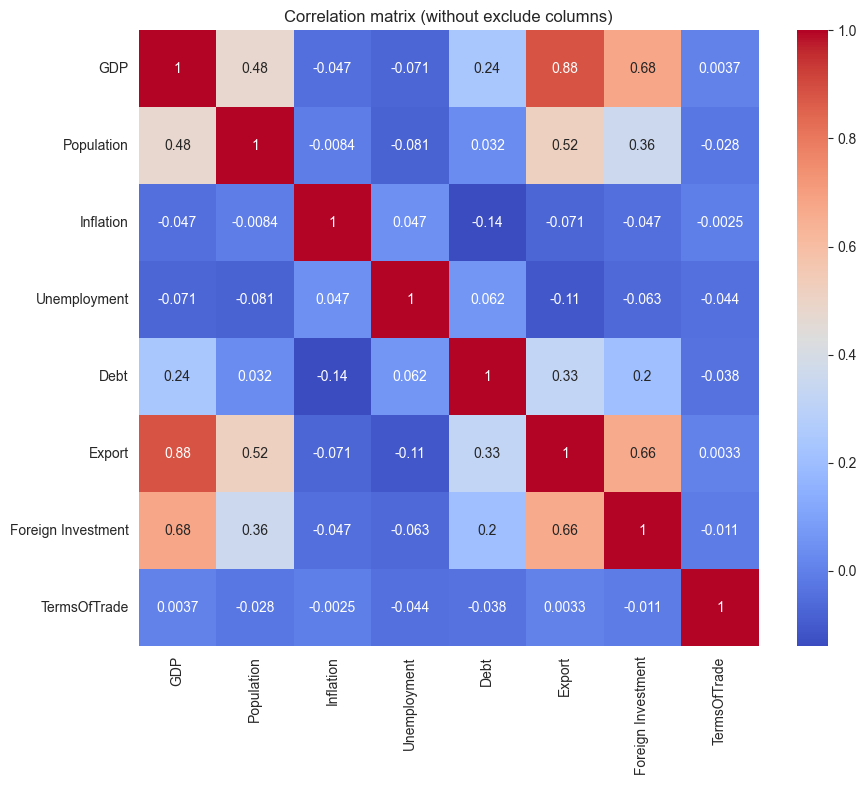

In [11]:
exclude = ['Country', 'Year','Group']

corr_cols = [col for col in df.columns if col not in exclude]
plt.figure(figsize=(10, 8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix (without exclude columns)')
plt.show()

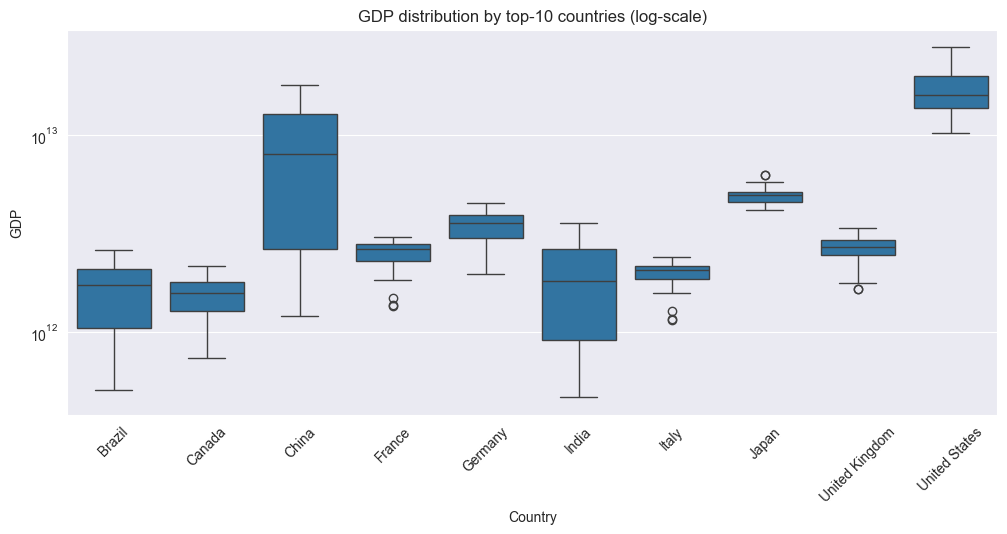

In [12]:
top10 = df.groupby('Country')['GDP'].mean().sort_values(ascending=False).head(10).index
plt.figure(figsize=(12, 5))
sns.boxplot(x='Country', y='GDP', data=df[df['Country'].isin(top10)])
plt.xticks(rotation=45)
plt.title('GDP distribution by top-10 countries (log-scale)')
plt.yscale('log')
plt.show()

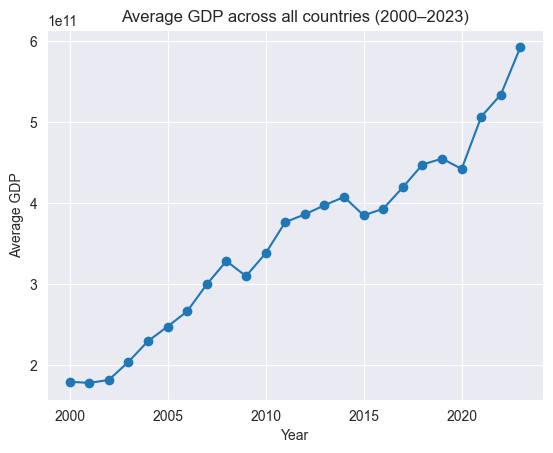

In [13]:
gdp_trend = df.groupby('Year')['GDP'].mean()
plt.plot(gdp_trend.index, gdp_trend.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Average GDP')
plt.title('Average GDP across all countries (2000–2023)')
plt.show()


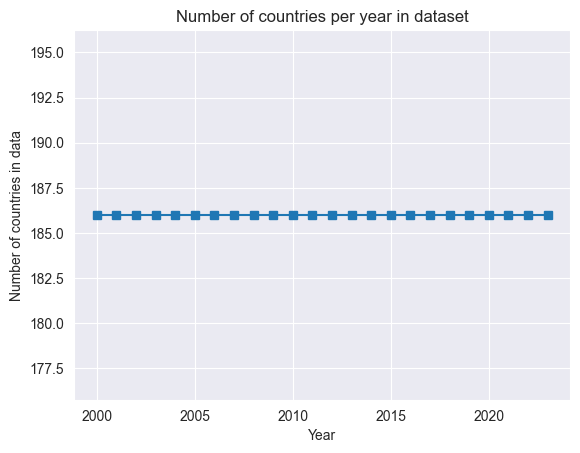

In [14]:
countries_by_year = df.groupby('Year')['Country'].nunique()
plt.plot(countries_by_year.index, countries_by_year.values, marker='s')
plt.xlabel('Year')
plt.ylabel('Number of countries in data')
plt.title('Number of countries per year in dataset')
plt.show()


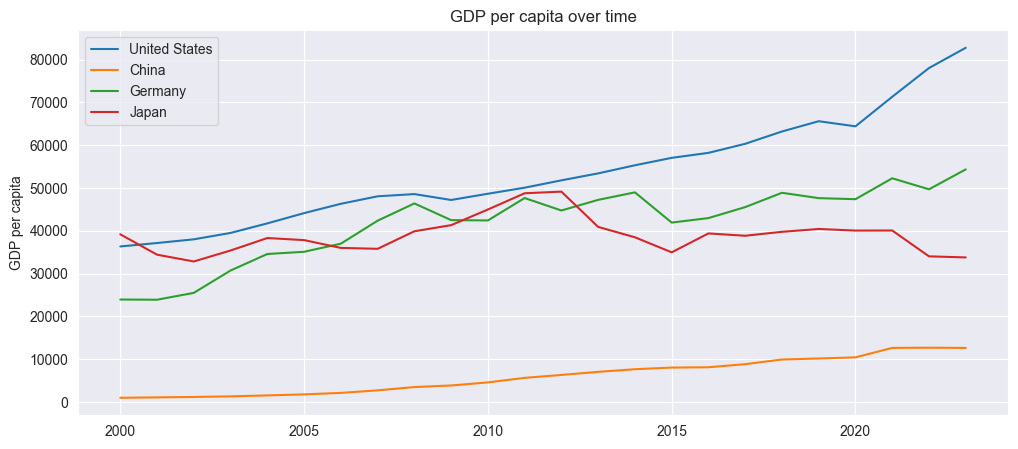

In [15]:
df['GDP_per_capita'] = df['GDP'] / df['Population']
plt.figure(figsize=(12, 5))
for country in ['United States', 'China', 'Germany', 'Japan']:
    plt.plot(df[df['Country'] == country]['Year'], df[df['Country'] == country]['GDP_per_capita'], label=country)
plt.legend()
plt.title('GDP per capita over time')
plt.ylabel('GDP per capita')
plt.show()

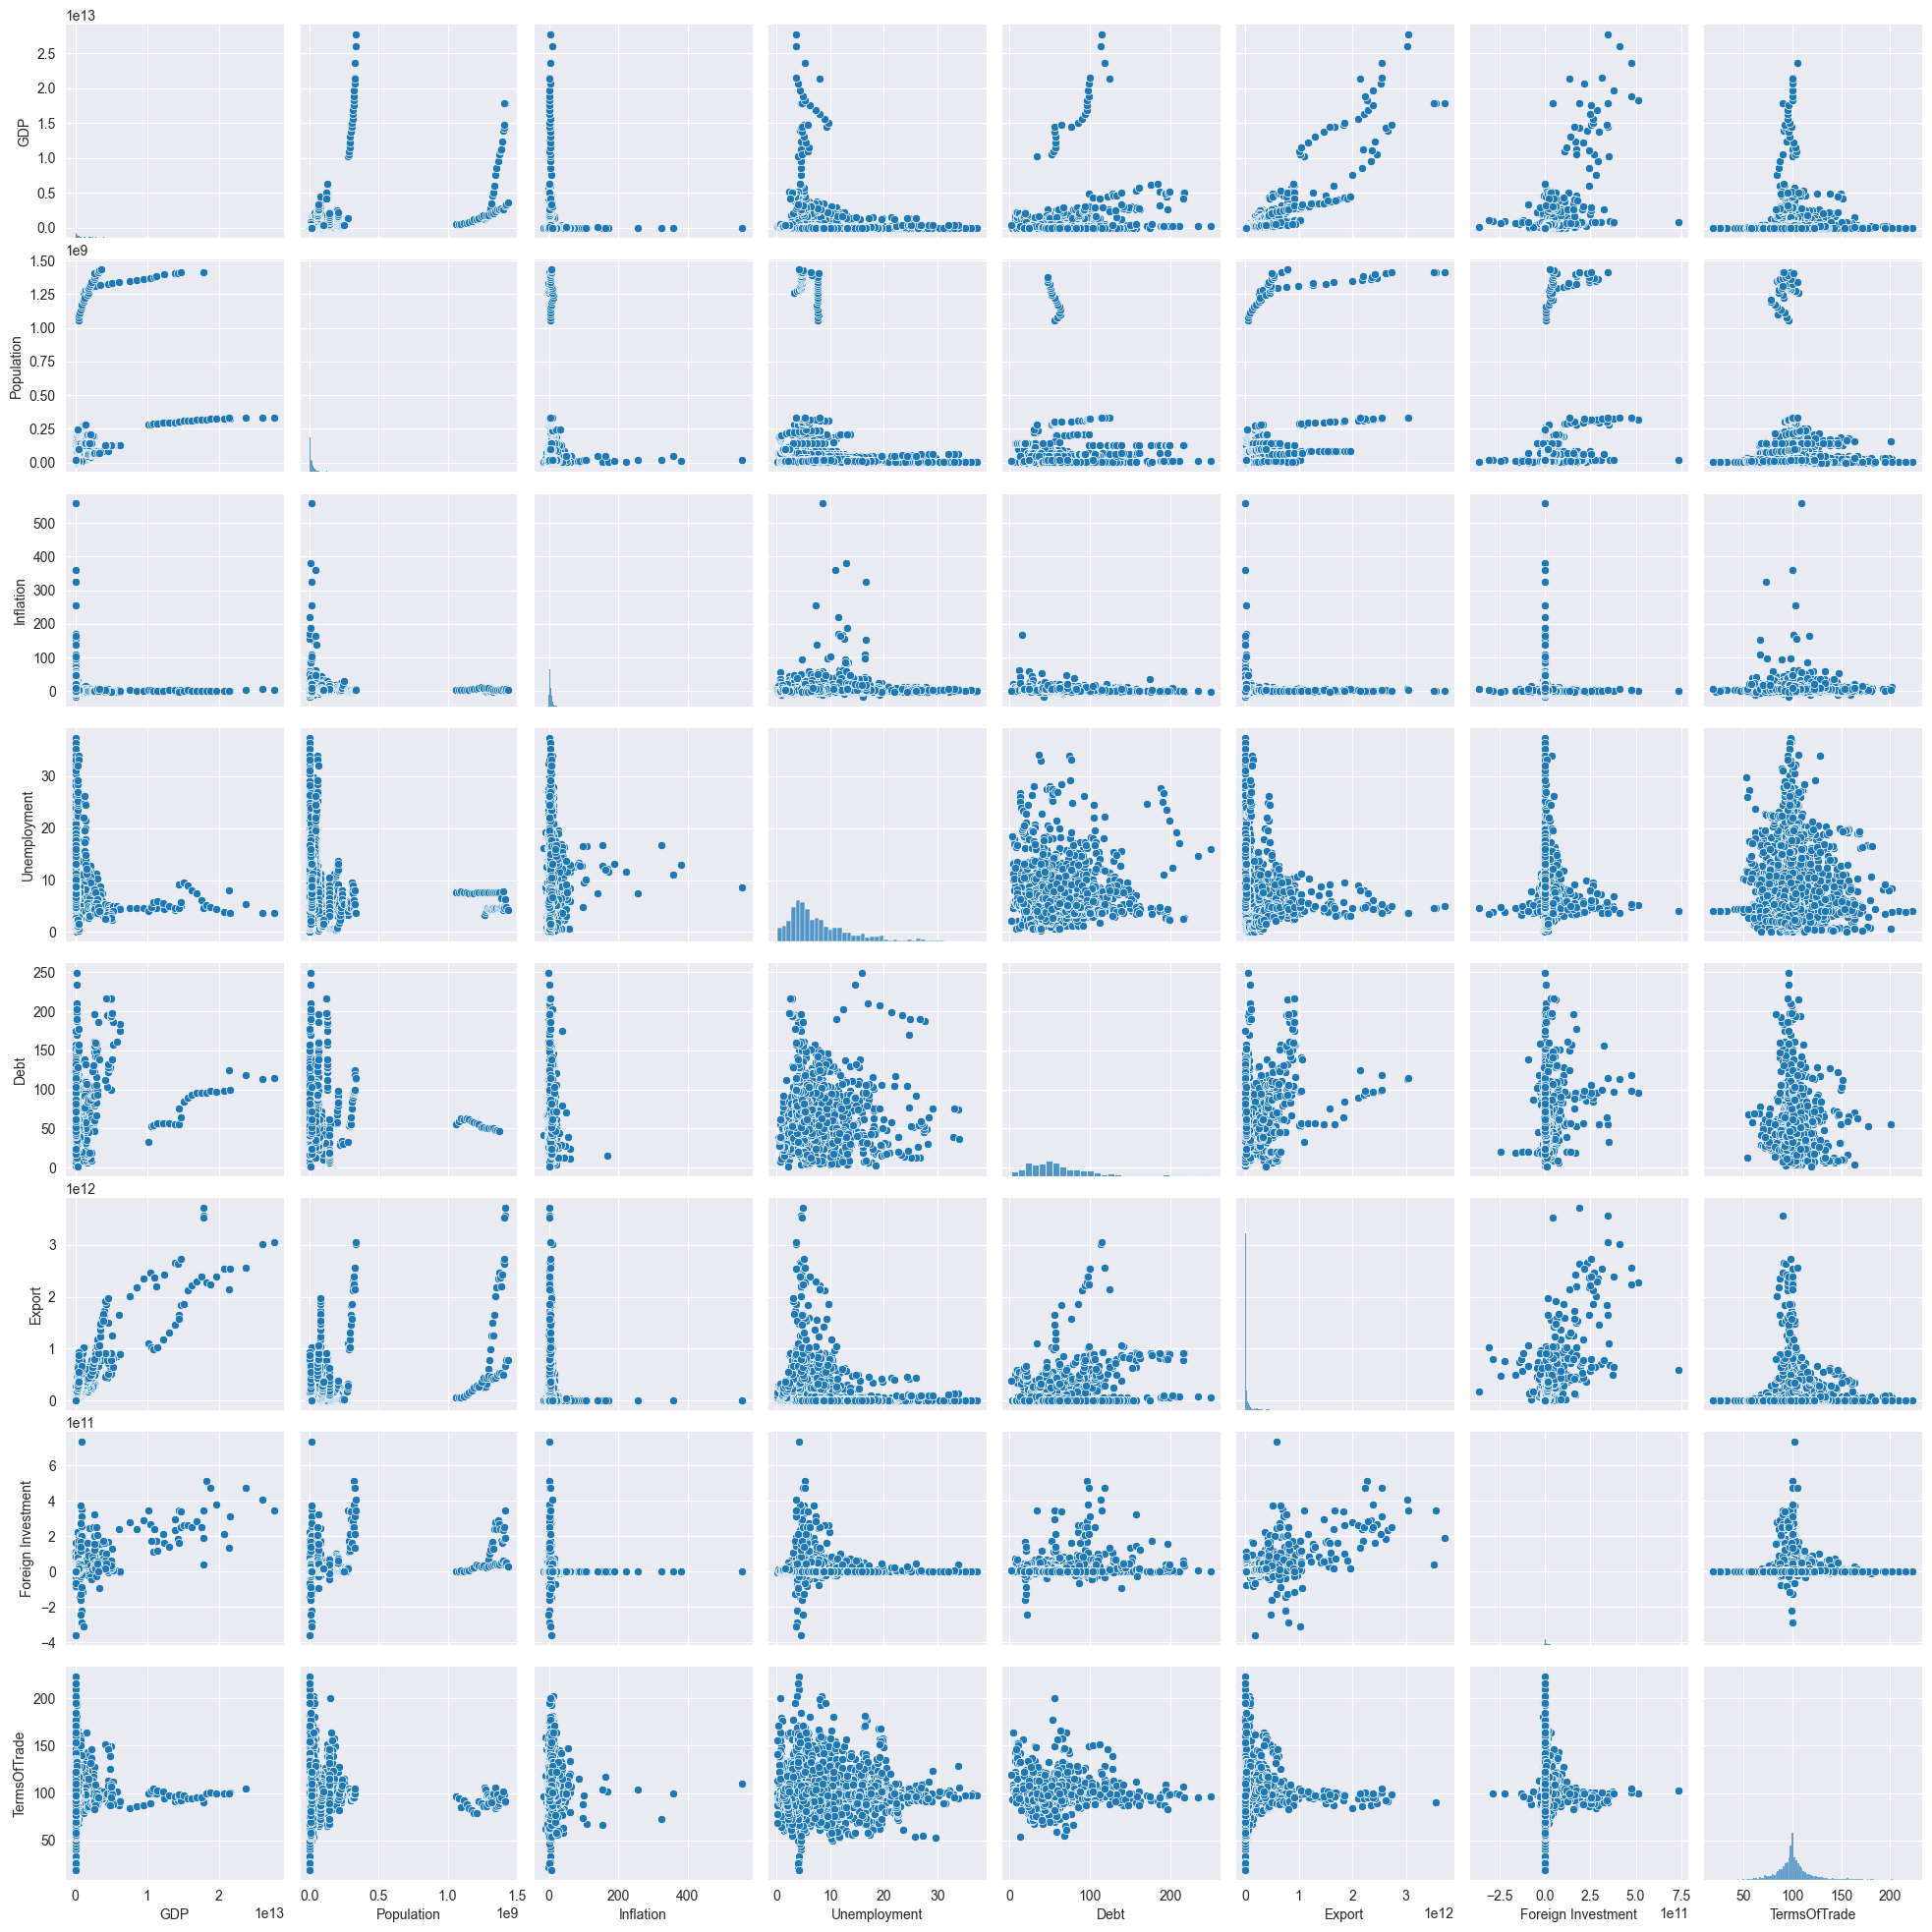

In [16]:

sns.pairplot(df[corr_cols])
plt.show()



In [17]:
top_capita = df[df['Year']==2023].sort_values('GDP_per_capita', ascending=False).head(10)
print(top_capita[['Country', 'GDP_per_capita']])

              Country  GDP_per_capita
10723          Monaco   256580.515123
9553       Luxembourg   128678.189943
1623          Bermuda   125841.602522
7538          Ireland   103887.800388
15338     Switzerland    99564.710026
2663   Cayman Islands    97749.507896
11893          Norway    87925.094419
13843       Singapore    84734.255921
16508   United States    82769.412211
13063           Qatar    80195.874647


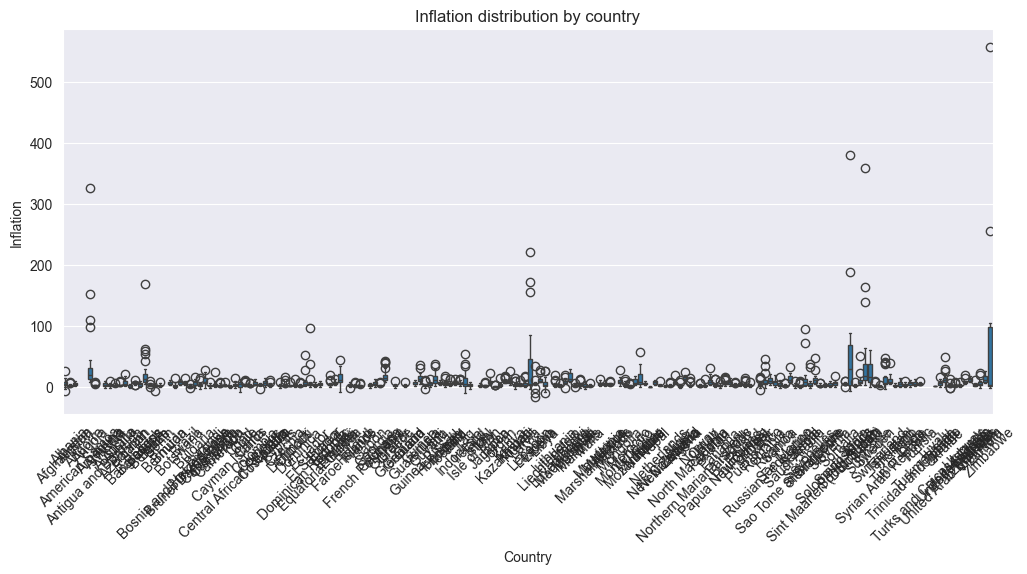

In [18]:
plt.figure(figsize=(12,5))
sns.boxplot(x='Country', y='Inflation', data=df)
plt.xticks(rotation=45)
plt.title('Inflation distribution by country')
plt.show()

Data Preprocessing

In [19]:

df = df.drop(columns=['Debt'])

countries_before = df['Country'].nunique()
rows_before = df.shape[0]

for col in ['Inflation', 'Unemployment', 'Export', 'Foreign Investment', 'TermsOfTrade']:
    df[col] = df.groupby('Country')[col].transform(lambda x: x.fillna(x.mean()))

df = df.dropna(subset=['GDP'])

df = df.dropna()

countries_after = df['Country'].nunique()

rows_after = df.shape[0]

print("Missing values after full preprocessing:\n", df.isnull().sum())
print("Final shape:", df.shape)
print("Countries before dropna:", countries_before)
print("Countries after dropna:", countries_after)
print("Rows before dropna:", rows_before)
print("Rows after dropna:", rows_after)


Missing values after full preprocessing:
 Country               0
Year                  0
GDP                   0
Population            0
Inflation             0
Unemployment          0
Export                0
Foreign Investment    0
TermsOfTrade          0
Group                 0
GDP_per_capita        0
dtype: int64
Final shape: (3403, 11)
Countries before dropna: 186
Countries after dropna: 142
Rows before dropna: 4464
Rows after dropna: 3403


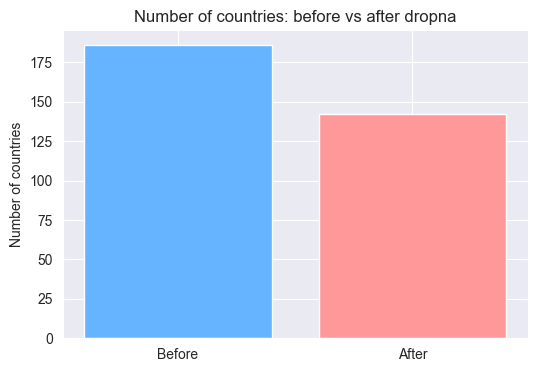

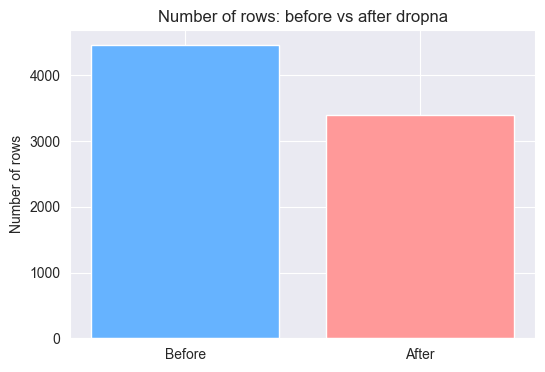

In [20]:
plt.figure(figsize=(6, 4))
plt.bar(['Before', 'After'], [countries_before, countries_after], color=['#66b3ff', '#ff9999'])
plt.title('Number of countries: before vs after dropna')
plt.ylabel('Number of countries')
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['Before', 'After'], [rows_before, rows_after], color=['#66b3ff', '#ff9999'])
plt.title('Number of rows: before vs after dropna')
plt.ylabel('Number of rows')
plt.show()

df.to_csv('macro_preprocessed.csv', index=False)


Feature Engineering

In [21]:
df = df.sort_values(['Country', 'Year'])
df['GDP_growth'] = df.groupby('Country')['GDP'].pct_change(fill_method=None)


In [22]:
df['Population_growth'] = df.groupby('Country')['Population'].pct_change(fill_method=None)

In [23]:

df['Export_to_GDP'] = df['Export'] / df['GDP']



In [24]:
df['GDP_growth'] = df['GDP_growth'].fillna(0)
df['Population_growth'] = df['Population_growth'].fillna(0)
df['Population'] = df['Population'].astype(int)


In [25]:
pca_features = [
    'Population', 'Inflation', 'Unemployment', 'Export',
    'Foreign Investment', 'TermsOfTrade',
    'GDP_growth', 'Population_growth', 'Export_to_GDP'
]

X_pca_input = df[pca_features].fillna(df[pca_features].mean())

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca_input)

pca = PCA(n_components=1)
df['PCA_1'] = pca.fit_transform(X_pca_scaled)[:, 0]



As an additional feature, the first PCA component on quantitative macroeconomic indicators was added. It aggregates the overall ‘economic strength’ and correlates with the latent macro factors of growth/decline.

In [26]:
df.head(30)

,Country,Year,GDP,Population,Inflation,Unemployment,Export,Foreign Investment,TermsOfTrade,Group,GDP_per_capita,GDP_growth,Population_growth,Export_to_GDP,PCA_1
40,Afghanistan,2000,3.521418e+09,20130327,5.877462,7.935,2.420057e+09,1.700000e+05,61.221057,Other,174.930991,0.000000,0.000000,0.687239,-0.242398
41,Afghanistan,2001,2.813572e+09,20284307,5.877462,7.953,2.420057e+09,6.800000e+05,72.363817,Other,138.706822,-0.201012,0.007649,0.860137,-0.298463
42,Afghanistan,2002,3.825701e+09,21378117,5.877462,7.930,2.420057e+09,5.000000e+07,71.320607,Other,178.954088,0.359731,0.053924,0.632579,-0.837109
43,Afghanistan,2003,4.520947e+09,22733049,5.877462,7.880,2.420057e+09,5.780000e+07,67.324304,Other,198.871116,0.181730,0.063379,0.535299,-0.834333
44,Afghanistan,2004,5.224897e+09,23560654,5.877462,7.899,2.420057e+09,1.869000e+08,74.730184,Other,221.763654,0.155709,0.036405,0.463178,-0.595485
45,Afghanistan,2005,6.203257e+09,24404567,12.686269,7.885,2.420057e+09,2.710000e+08,76.094588,Other,254.184249,0.187250,0.035819,0.390127,-0.621740
46,Afghanistan,2006,6.971758e+09,25424094,6.784597,7.914,2.420057e+09,2.380000e+08,81.220684,Other,274.218554,0.123887,0.041776,0.347123,-0.629744
47,Afghanistan,2007,9.747886e+09,25909852,8.680571,7.817,2.420057e+09,1.886900e+08,83.499343,Other,376.223152,0.398196,0.019106,0.248265,-0.516373
48,Afghanistan,2008,1.010930e+10,26482622,26.418664,7.878,2.420057e+09,4.603374e+07,84.699868,Other,381.733238,0.037076,0.022106,0.239389,-0.517105
49,Afghanistan,2009,1.241615e+10,27466101,-6.811161,7.754,2.420057e+09,5.610725e+07,90.087245,Other,452.053705,0.228192,0.037137,0.194912,-0.550192


In [27]:
df.shape

(3403, 15)

In [28]:
exclude = ['GDP', 'Country', 'Year', 'Group']
feature_cols = [col for col in df.columns if col not in exclude]

group_datasets = {}

for group_name in df['Group'].unique():
    print(f"\n📊 Group: {group_name}")

    df_group = df[df['Group'] == group_name]

    train = df_group[df_group['Year'] <= 2018]
    test = df_group[df_group['Year'] > 2018]

    X_train = train[feature_cols]
    y_train = train['GDP']
    X_test = test[feature_cols]
    y_test = test['GDP']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("  ➤ Train shape:", X_train_scaled.shape)
    print("  ➤ Test shape:", X_test_scaled.shape)
    print("  ➤ Train years:", train['Year'].unique())
    print("  ➤ Test years:", test['Year'].unique())

    group_datasets[group_name] = {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train.values,
        'y_test': y_test.values,
        'scaler': scaler,
        'train_df': train,
        'test_df': test
    }



📊 Group: Other
  ➤ Train shape: (2489, 11)
  ➤ Test shape: (650, 11)
  ➤ Train years: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]
  ➤ Test years: [2019 2020 2021 2022 2023]

📊 Group: BRICS
  ➤ Train shape: (76, 11)
  ➤ Test shape: (20, 11)
  ➤ Train years: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]
  ➤ Test years: [2019 2020 2021 2022 2023]

📊 Group: G7
  ➤ Train shape: (133, 11)
  ➤ Test shape: (35, 11)
  ➤ Train years: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]
  ➤ Test years: [2019 2020 2021 2022 2023]


“To better reflect a real-world forecasting scenario and avoid data leakage, we split our data by years: 2000–2018 for training, 2019–2023 for testing. Standardization was performed on training data only, and the same scaling was applied to the test set.”

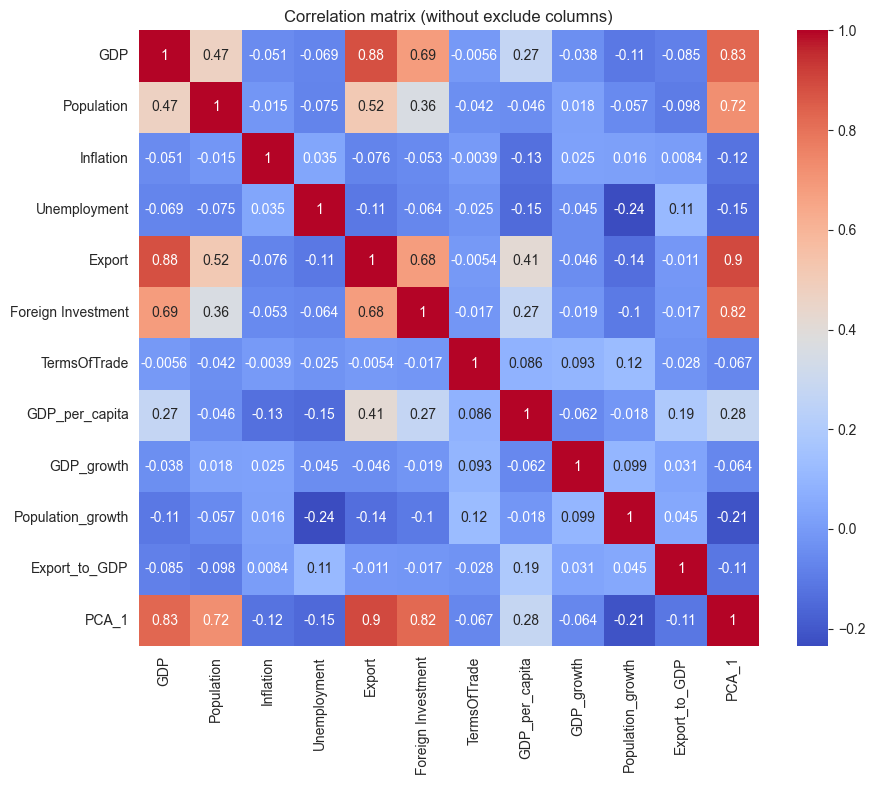

In [29]:
exclude = ['Country', 'Year','Group']

corr_cols = [col for col in df.columns if col not in exclude]

plt.figure(figsize=(10, 8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix (without exclude columns)')
plt.show()


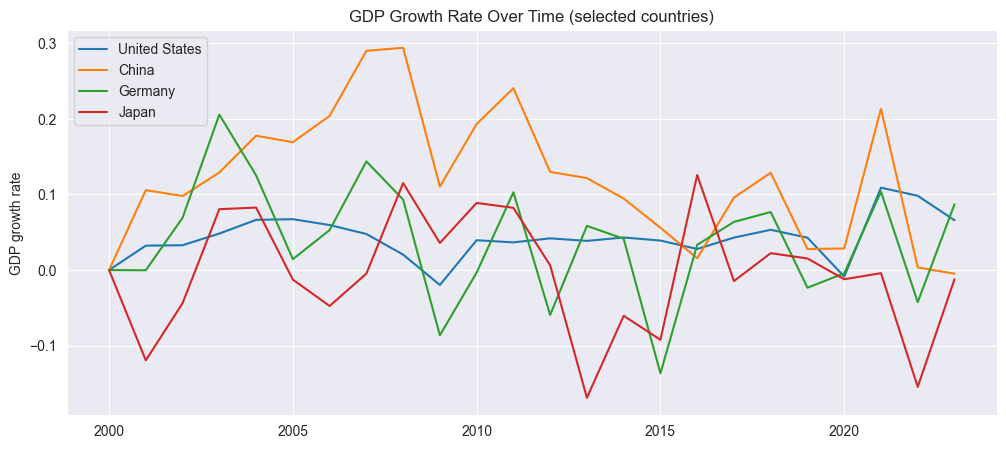

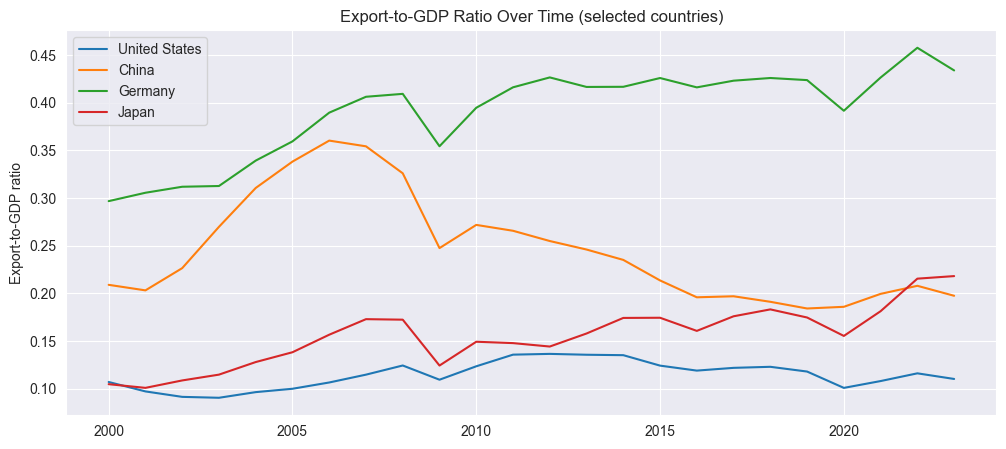

In [31]:
plt.figure(figsize=(12, 5))
for country in ['United States', 'China', 'Germany', 'Japan']:
    plt.plot(df[df['Country'] == country]['Year'],
             df[df['Country'] == country]['GDP_growth'],
             label=country)
plt.legend()
plt.title('GDP Growth Rate Over Time (selected countries)')
plt.ylabel('GDP growth rate')
plt.show()

plt.figure(figsize=(12, 5))
for country in ['United States', 'China', 'Germany', 'Japan']:
    plt.plot(df[df['Country'] == country]['Year'],
             df[df['Country'] == country]['Export_to_GDP'],
             label=country)
plt.legend()
plt.title('Export-to-GDP Ratio Over Time (selected countries)')
plt.ylabel('Export-to-GDP ratio')
plt.show()


Modelling

In [32]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(),
    "MLP": MLPRegressor(random_state=42, max_iter=1000),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42),
}

voting = VotingRegressor([
    ('lr', models["Linear Regression"]),
    ('ridge', models["Ridge Regression"]),
    ('rf', models["Random Forest"])
])
stacking = StackingRegressor([
    ('lr', models["Linear Regression"]),
    ('ridge', models["Ridge Regression"]),
    ('rf', models["Random Forest"]),
    ('gb', models["Gradient Boosting"])
])

models["Voting"] = voting
models["Stacking"] = stacking


In [33]:
group_cv_results = {}
group_test_results = {}
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

for group_name, data in group_datasets.items():
    print(f"\n🔍 Group: {group_name}")

    X_train = data['X_train_scaled']
    y_train = data['y_train']
    X_test = data['X_test_scaled']
    y_test = data['y_test']

    cv_rows = []
    test_rows = []

    for name, model in models.items():
        try:
            scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
            cv_rows.append({
                'Model': name,
                'RMSE': -scores['test_RMSE'].mean(),
                'MAE': -scores['test_MAE'].mean(),
                'R2': scores['test_R2'].mean()
            })
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            test_rows.append({
                'Model': name,
                'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'Test MAE': mean_absolute_error(y_test, y_pred),
                'Test R2': r2_score(y_test, y_pred)
            })

        except Exception as e:
            print(f"Model {name} failed for {group_name}: {e}")

    group_cv_results[group_name] = pd.DataFrame(cv_rows).sort_values("RMSE")
    group_test_results[group_name] = pd.DataFrame(test_rows).sort_values("Test RMSE")



🔍 Group: Other


C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.224e+24, tolerance: 1.446e+22
  model = cd_fast.enet_coordinate_descent(
C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 2489, number of used features: 11
[LightGBM] [Info] Start training from score 116264374243.754120


C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



🔍 Group: BRICS


C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+24, tolerance: 7.291e+22
  model = cd_fast.enet_coordinate_descent(
C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 11
[LightGBM] [Info] Start training from score 2360745328963.368652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



🔍 Group: G7


C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.920e+24, tolerance: 2.798e+23
  model = cd_fast.enet_coordinate_descent(
C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 133, number of used features: 11
[LightGBM] [Info] Start training from score 4492522702647.819336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

C:\Users\falco\Desktop\ML Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [34]:

print("\n📈 Cross-Validation Results (G7):")
print(group_cv_results['G7'])

print("\n🧪 Test Results (BRICS):")
print(group_test_results['BRICS'])

print("\n🧪 Test Results (Other):")
print(group_test_results['Other'])



📈 Cross-Validation Results (G7):
                Model          RMSE           MAE            R2
0   Linear Regression  1.310733e+12  1.012593e+12 -2.237100e+00
2               Lasso  1.310733e+12  1.012593e+12 -2.237100e+00
12             Voting  1.699338e+12  1.373827e+12 -6.004738e-01
1    Ridge Regression  1.737241e+12  1.416750e+12 -1.859325e+00
3          ElasticNet  2.022186e+12  1.648924e+12 -1.305860e+00
10            XGBoost  2.046725e+12  1.672460e+12  3.057487e-01
5   Gradient Boosting  2.192566e+12  1.788115e+12 -1.157480e-01
6            AdaBoost  2.367325e+12  1.924197e+12 -6.608662e-01
4       Random Forest  2.484918e+12  1.984842e+12 -1.042961e+00
11           LightGBM  2.809549e+12  2.259878e+12 -8.855155e-01
7                 KNN  2.824668e+12  2.345883e+12 -9.862165e-01
8                 SVR  3.265804e+12  2.774125e+12 -2.612552e+00
9                 MLP  4.957910e+12  4.541383e+12 -1.092848e+01
13           Stacking  5.947977e+24  5.505154e+24 -3.398939e+26

🧪 Tes

In [35]:
summary = []
for group_name in group_test_results:
    best_row = group_test_results[group_name].iloc[0]
    summary.append({
        'Group': group_name,
        'Best Model': best_row['Model'],
        'Test RMSE': best_row['Test RMSE'],
        'Test MAE': best_row['Test MAE'],
        'Test R2': best_row['Test R2']
    })

summary_df = pd.DataFrame(summary)
print("\n🏆 Best models per group:")
print(summary_df)



🏆 Best models per group:
   Group         Best Model     Test RMSE      Test MAE   Test R2
0  Other  Gradient Boosting  5.950175e+10  2.243466e+10  0.966789
1  BRICS   Ridge Regression  6.347602e+11  4.080474e+11  0.990463
2     G7            XGBoost  1.621290e+12  6.814543e+11  0.952573



Group: Other — top 3 models:
                Model     Test RMSE      Test MAE   Test R2
5   Gradient Boosting  5.950175e+10  2.243466e+10  0.966789
11           LightGBM  6.225312e+10  1.959928e+10  0.963647
10            XGBoost  6.478683e+10  2.165090e+10  0.960628


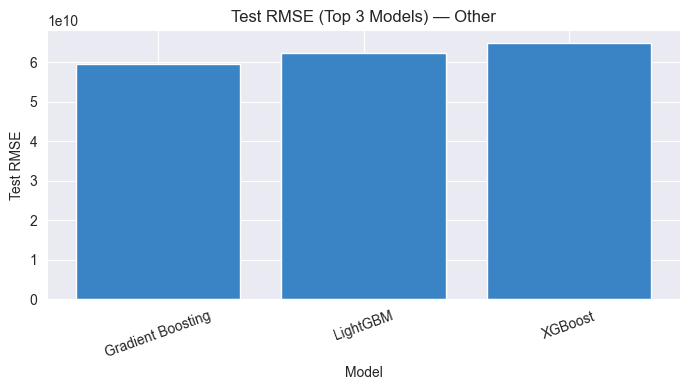

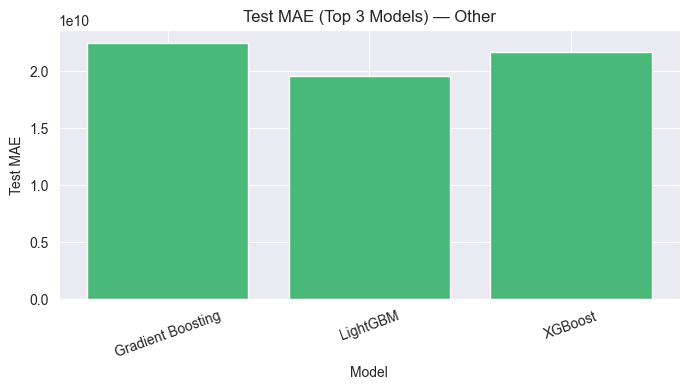

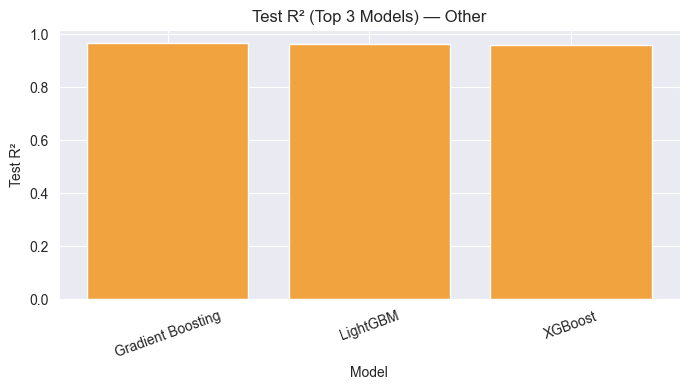


Group: BRICS — top 3 models:
               Model     Test RMSE      Test MAE   Test R2
1   Ridge Regression  6.347602e+11  4.080474e+11  0.990463
2              Lasso  9.267365e+11  6.119747e+11  0.979672
0  Linear Regression  9.267365e+11  6.119747e+11  0.979672


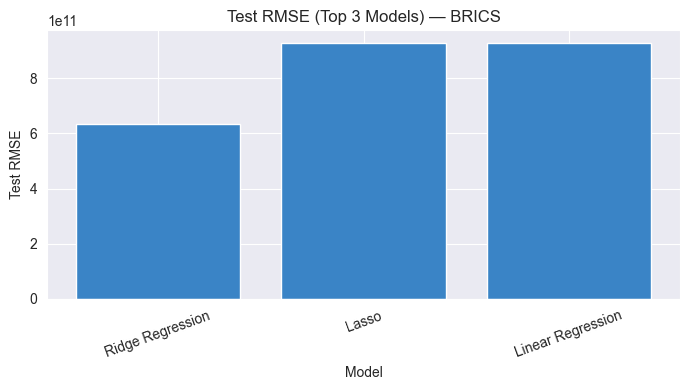

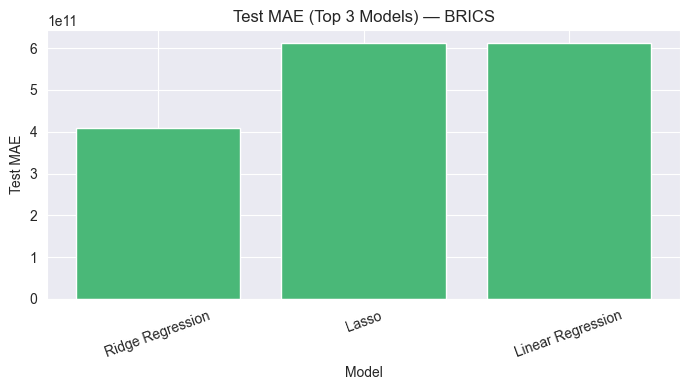

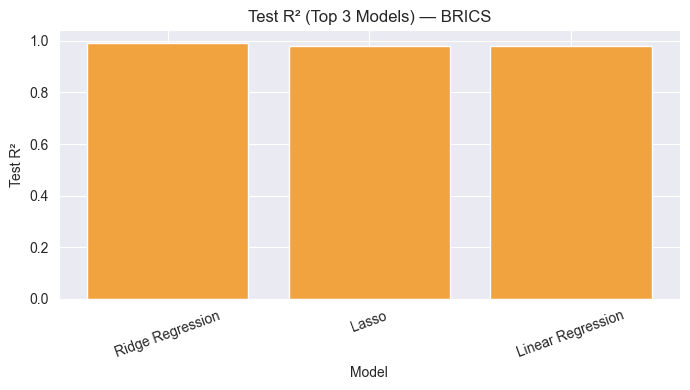


Group: G7 — top 3 models:
                Model     Test RMSE      Test MAE   Test R2
10            XGBoost  1.621290e+12  6.814543e+11  0.952573
5   Gradient Boosting  2.027119e+12  8.666271e+11  0.925858
6            AdaBoost  2.032140e+12  9.311957e+11  0.925490


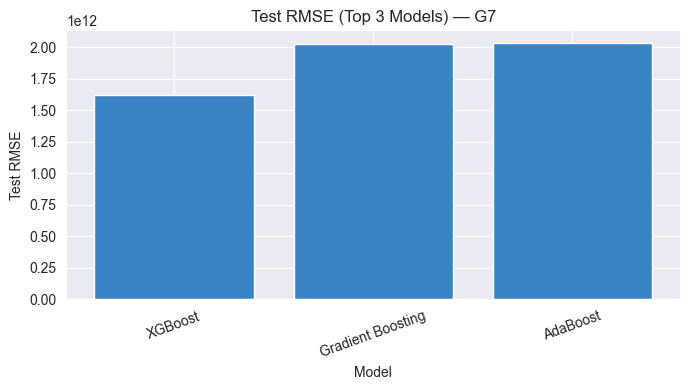

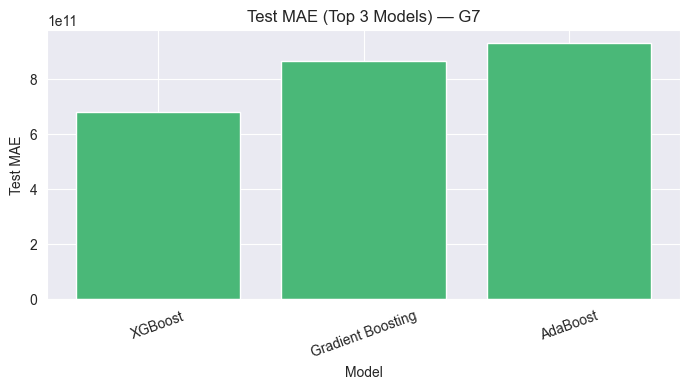

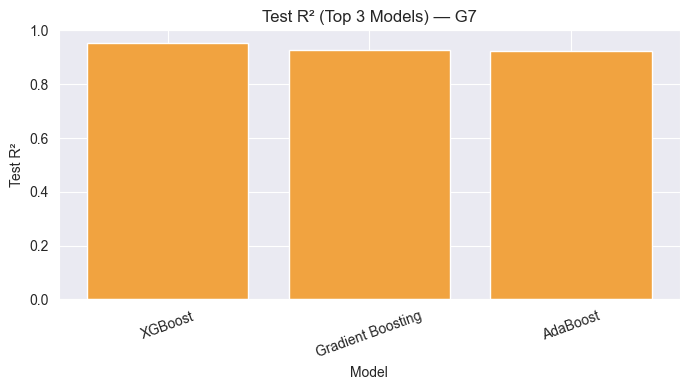

In [36]:

top_n = 3
metrics = [
    ('Test RMSE', 'Test RMSE', '#3A84C6'),
    ('Test MAE', 'Test MAE', '#4AB878'),
    ('Test R2',  'Test R²',  '#F1A340')
]

groups = list(group_test_results.keys())

for group in groups:
    df_group = group_test_results[group].sort_values('Test RMSE').head(top_n)
    print(f"\nGroup: {group} — top {top_n} models:")
    print(df_group[['Model', 'Test RMSE', 'Test MAE', 'Test R2']])

    for metric, title, color in metrics:
        plt.figure(figsize=(7,4))
        plt.bar(df_group['Model'], df_group[metric], color=color)
        plt.title(f'{title} (Top {top_n} Models) — {group}')
        plt.ylabel(title)
        plt.xlabel('Model')
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()


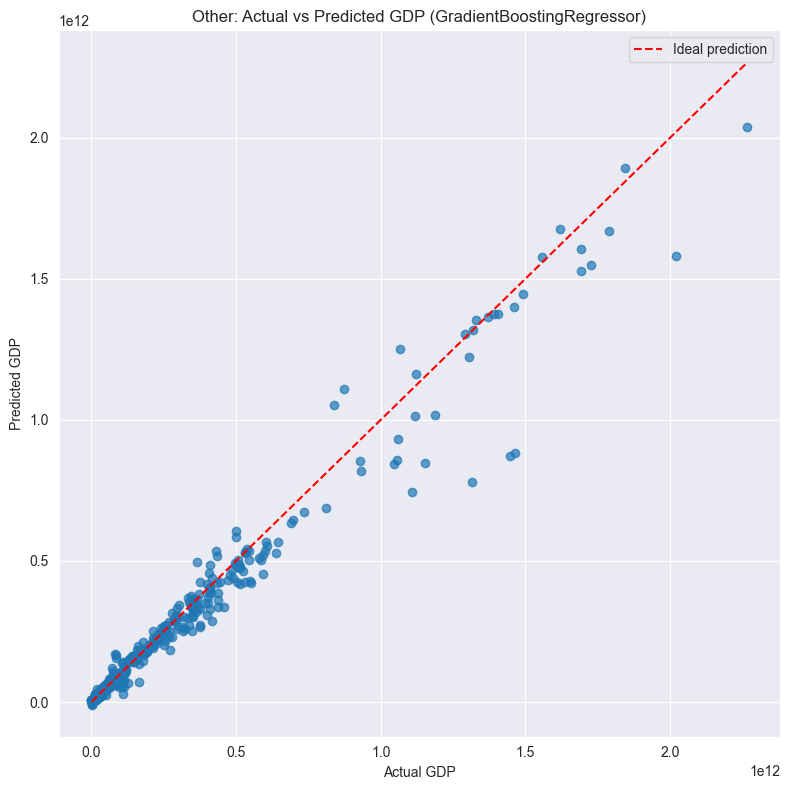

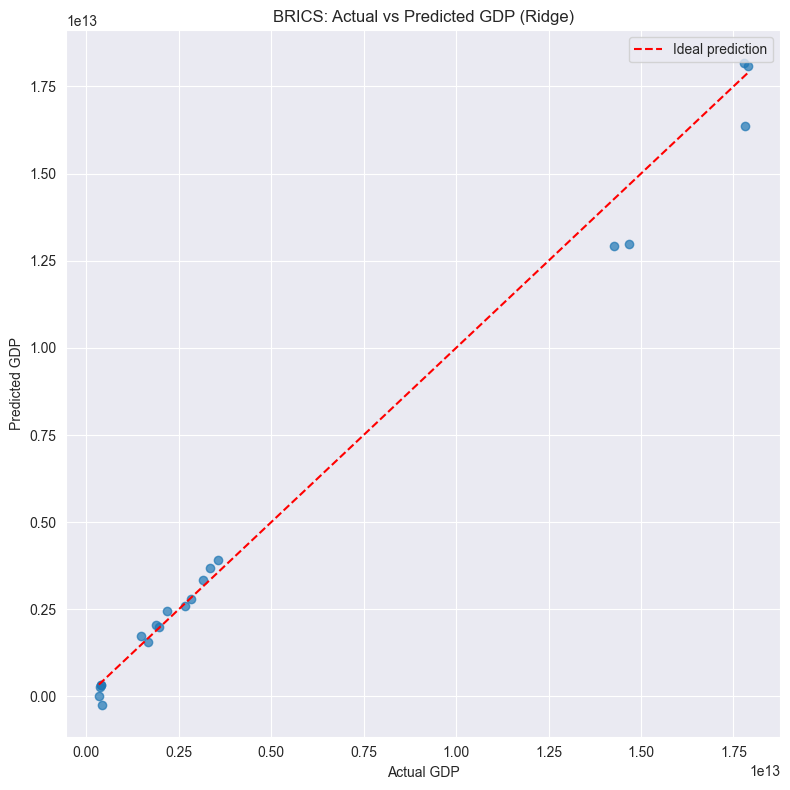

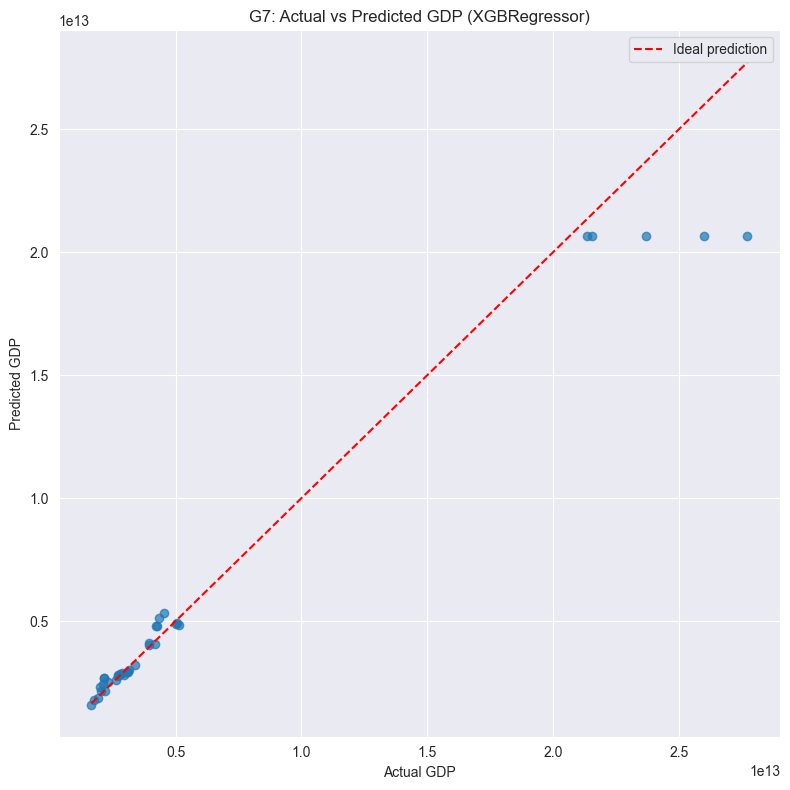

In [37]:


best_models = {
    'Other': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'BRICS': Ridge(alpha=1.0),
    'G7': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

for group in ['Other', 'BRICS', 'G7']:
    data = group_datasets[group]
    X_train = data['X_train_scaled']
    y_train = data['y_train']
    X_test = data['X_test_scaled']
    y_test = data['y_test']

    model = best_models[group]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal prediction')
    plt.xlabel('Actual GDP')
    plt.ylabel('Predicted GDP')
    plt.title(f'{group}: Actual vs Predicted GDP ({model.__class__.__name__})')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [38]:

data_g7 = group_datasets['G7']
X_train_g7_scaled = data_g7['X_train_scaled']
X_test_g7_scaled = data_g7['X_test_scaled']
y_train_g7 = data_g7['y_train']
y_test_g7 = data_g7['y_test']
test_g7 = data_g7['test_df']

xgb_g7 = xgb.XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, subsample=0.8, random_state=42)
xgb_g7.fit(X_train_g7_scaled, y_train_g7)
y_pred_xgb_g7 = xgb_g7.predict(X_test_g7_scaled)

test_xgb_g7 = test_g7.copy().reset_index(drop=True)
test_xgb_g7['Predicted_GDP'] = y_pred_xgb_g7
test_xgb_g7['Actual_GDP'] = y_test_g7

print(test_xgb_g7.groupby('Country')[['Predicted_GDP', 'Actual_GDP']].mean())


                Predicted_GDP    Actual_GDP
Country                                    
Canada           2.105817e+12  1.942167e+12
France           2.797345e+12  2.837057e+12
Germany          4.531830e+12  4.186990e+12
Italy            2.236414e+12  2.102047e+12
Japan            4.687772e+12  4.733821e+12
United Kingdom   2.984682e+12  3.037281e+12
United States    2.065153e+13  2.406057e+13


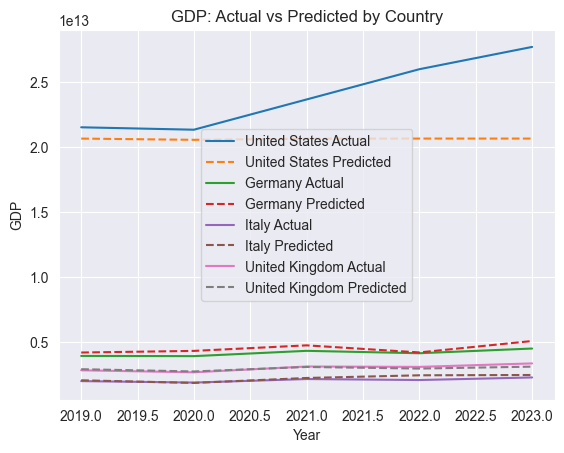

In [39]:
for country in ['United States','Germany','Italy','United Kingdom']:
    data = test_xgb_g7[test_xgb_g7['Country'] == country].sort_values('Year')
    plt.plot(data['Year'], data['Actual_GDP'], label=f'{country} Actual')
    plt.plot(data['Year'], data['Predicted_GDP'], '--', label=f'{country} Predicted')
plt.legend()
plt.title('GDP: Actual vs Predicted by Country')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.show()


Model Tuning

Define best parameters

In [40]:


best_model_types = {
    'G7': 'XGBoost',
    'BRICS': 'Ridge Regression',
    'Other': 'Gradient Boosting'
}

param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 8],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 1]
    },
    'Ridge Regression': {
        'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 8],
        'learning_rate': [0.05, 0.1, 0.2]
    }
}

model_map = {
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0),
    'Ridge Regression': Ridge(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

best_estimators = {}

for group in best_model_types:
    print(f"\n🔧 Tuning for group: {group} ({best_model_types[group]})")
    data = group_datasets[group]
    X_train = data['X_train_scaled']
    y_train = data['y_train']
    model = model_map[best_model_types[group]]
    param_grid = param_grids[best_model_types[group]]

    grid = GridSearchCV(model, param_grid=param_grid, cv=3,
                        scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[group] = grid.best_estimator_
    print(f"  Best params: {grid.best_params_}")




🔧 Tuning for group: G7 (XGBoost)
  Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

🔧 Tuning for group: BRICS (Ridge Regression)
  Best params: {'alpha': 0.1}

🔧 Tuning for group: Other (Gradient Boosting)
  Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


G7 (XGBoost)

In [41]:


data_g7 = group_datasets['G7']
X_train_g7 = data_g7['X_train_scaled']
y_train_g7 = data_g7['y_train']
X_test_g7 = data_g7['X_test_scaled']
y_test_g7 = data_g7['y_test']

xgb_untuned = xgb.XGBRegressor(random_state=42, verbosity=0)
xgb_untuned.fit(X_train_g7, y_train_g7)
y_pred_untuned = xgb_untuned.predict(X_test_g7)

xgb_tuned = xgb.XGBRegressor(
    n_estimators=300, max_depth=3, learning_rate=0.05, subsample=0.8, random_state=42, verbosity=0)

xgb_tuned.fit(X_train_g7, y_train_g7)
y_pred_tuned = xgb_tuned.predict(X_test_g7)

results_g7 = [
    {'Model': 'XGBoost', 'Type': 'Untuned',
     'Test RMSE': np.sqrt(mean_squared_error(y_test_g7, y_pred_untuned)),
     'Test MAE': mean_absolute_error(y_test_g7, y_pred_untuned),
     'Test R2': r2_score(y_test_g7, y_pred_untuned)
     },
    {'Model': 'XGBoost', 'Type': 'Tuned',
     'Test RMSE': np.sqrt(mean_squared_error(y_test_g7, y_pred_tuned)),
     'Test MAE': mean_absolute_error(y_test_g7, y_pred_tuned),
     'Test R2': r2_score(y_test_g7, y_pred_tuned)
     }
]


In [42]:
results_g7

[{'Model': 'XGBoost',
  'Type': 'Untuned',
  'Test RMSE': np.float64(1621289874614.7556),
  'Test MAE': 681454346658.1729,
  'Test R2': 0.9525727144956091},
 {'Model': 'XGBoost',
  'Type': 'Tuned',
  'Test RMSE': np.float64(1635286828875.1755),
  'Test MAE': 633594282939.2249,
  'Test R2': 0.9517502791192383}]

BRICS (Ridge Regression)

In [43]:


data_brics = group_datasets['BRICS']
X_train_brics = data_brics['X_train_scaled']
y_train_brics = data_brics['y_train']
X_test_brics = data_brics['X_test_scaled']
y_test_brics = data_brics['y_test']

ridge_untuned = Ridge(random_state=42)
ridge_untuned.fit(X_train_brics, y_train_brics)
y_pred_untuned = ridge_untuned.predict(X_test_brics)

ridge_tuned = Ridge(alpha=0.1, random_state=42)
ridge_tuned.fit(X_train_brics, y_train_brics)
y_pred_tuned = ridge_tuned.predict(X_test_brics)
results_brics = [
    {'Model': 'Ridge Regression', 'Type': 'Untuned',
     'Test RMSE': np.sqrt(mean_squared_error(y_test_brics, y_pred_untuned)),
     'Test MAE': mean_absolute_error(y_test_brics, y_pred_untuned),
     'Test R2': r2_score(y_test_brics, y_pred_untuned)
     },
    {'Model': 'Ridge Regression', 'Type': 'Tuned',
     'Test RMSE': np.sqrt(mean_squared_error(y_test_brics, y_pred_tuned)),
     'Test MAE': mean_absolute_error(y_test_brics, y_pred_tuned),
     'Test R2': r2_score(y_test_brics, y_pred_tuned)
     }
]


In [44]:
results_brics

[{'Model': 'Ridge Regression',
  'Type': 'Untuned',
  'Test RMSE': np.float64(634760204085.4829),
  'Test MAE': 408047442831.5301,
  'Test R2': 0.9904630303528351},
 {'Model': 'Ridge Regression',
  'Type': 'Tuned',
  'Test RMSE': np.float64(860170494912.7074),
  'Test MAE': 581902019668.0701,
  'Test R2': 0.9824870179992464}]

Other (Gradient Boosting)

In [45]:

data_other = group_datasets['Other']
X_train_other = data_other['X_train_scaled']
y_train_other = data_other['y_train']
X_test_other = data_other['X_test_scaled']
y_test_other = data_other['y_test']

gb_untuned = GradientBoostingRegressor(random_state=42)
gb_untuned.fit(X_train_other, y_train_other)
y_pred_untuned = gb_untuned.predict(X_test_other)

gb_tuned = GradientBoostingRegressor(n_estimators=300, max_depth=3, learning_rate=0.1, random_state=42)
gb_tuned.fit(X_train_other, y_train_other)
y_pred_tuned = gb_tuned.predict(X_test_other)

results_other = [
    {'Model': 'Gradient Boosting', 'Type': 'Untuned',
     'Test RMSE': np.sqrt(mean_squared_error(y_test_other, y_pred_untuned)),
     'Test MAE': mean_absolute_error(y_test_other, y_pred_untuned),
     'Test R2': r2_score(y_test_other, y_pred_untuned)
     },
    {'Model': 'Gradient Boosting', 'Type': 'Tuned',
     'Test RMSE': np.sqrt(mean_squared_error(y_test_other, y_pred_tuned)),
     'Test MAE': mean_absolute_error(y_test_other, y_pred_tuned),
     'Test R2': r2_score(y_test_other, y_pred_tuned)
     }
]


In [46]:
results_other

[{'Model': 'Gradient Boosting',
  'Type': 'Untuned',
  'Test RMSE': np.float64(59501752287.71237),
  'Test MAE': 22434659617.767082,
  'Test R2': 0.9667894700036328},
 {'Model': 'Gradient Boosting',
  'Type': 'Tuned',
  'Test RMSE': np.float64(55694347462.345406),
  'Test MAE': 19327924086.02086,
  'Test R2': 0.9709036484667057}]

Comparison ( Tuned vs Untuned )

In [47]:

results_g7 = []
for name, model in [('XGBoost Untuned', xgb_untuned), ('XGBoost Tuned', xgb_tuned)]:
    y_pred = model.predict(X_test_g7)
    results_g7.append({
        'Model': 'XGBoost',
        'Type': 'Tuned' if 'Tuned' in name else 'Untuned',
        'Group': 'G7',
        'Test RMSE': np.sqrt(mean_squared_error(y_test_g7, y_pred)),
        'Test MAE': mean_absolute_error(y_test_g7, y_pred),
        'Test R2': r2_score(y_test_g7, y_pred)
    })
compare_df_g7 = pd.DataFrame(results_g7)

results_brics = []
for name, model in [('Ridge Untuned', ridge_untuned), ('Ridge Tuned', ridge_tuned)]:
    y_pred = model.predict(X_test_brics)
    results_brics.append({
        'Model': 'Ridge Regression',
        'Type': 'Tuned' if 'Tuned' in name else 'Untuned',
        'Group': 'BRICS',
        'Test RMSE': np.sqrt(mean_squared_error(y_test_brics, y_pred)),
        'Test MAE': mean_absolute_error(y_test_brics, y_pred),
        'Test R2': r2_score(y_test_brics, y_pred)
    })
compare_df_brics = pd.DataFrame(results_brics)

results_other = []
for name, model in [('GB Untuned', gb_untuned), ('GB Tuned', gb_tuned)]:
    y_pred = model.predict(X_test_other)
    results_other.append({
        'Model': 'Gradient Boosting',
        'Type': 'Tuned' if 'Tuned' in name else 'Untuned',
        'Group': 'Other',
        'Test RMSE': np.sqrt(mean_squared_error(y_test_other, y_pred)),
        'Test MAE': mean_absolute_error(y_test_other, y_pred),
        'Test R2': r2_score(y_test_other, y_pred)
    })
compare_df_other = pd.DataFrame(results_other)

compare_df = pd.concat([compare_df_g7, compare_df_brics, compare_df_other], ignore_index=True)
order = ['XGBoost', 'Ridge Regression', 'Gradient Boosting']

In [48]:
compare_df

,Model,Type,Group,Test RMSE,Test MAE,Test R2
0,XGBoost,Untuned,G7,1.621290e+12,6.814543e+11,0.952573
1,XGBoost,Tuned,G7,1.635287e+12,6.335943e+11,0.951750
2,Ridge Regression,Untuned,BRICS,6.347602e+11,4.080474e+11,0.990463
3,Ridge Regression,Tuned,BRICS,8.601705e+11,5.819020e+11,0.982487
4,Gradient Boosting,Untuned,Other,5.950175e+10,2.243466e+10,0.966789
5,Gradient Boosting,Tuned,Other,5.569435e+10,1.932792e+10,0.970904


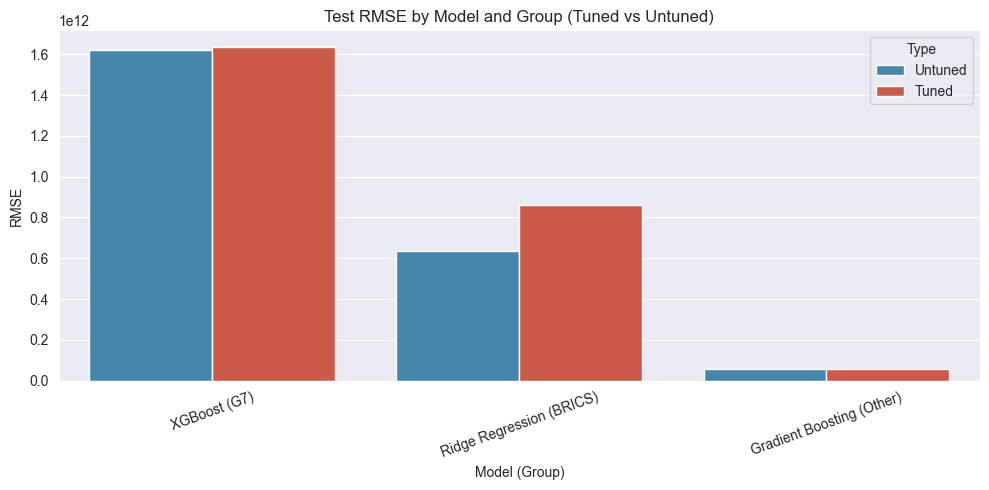

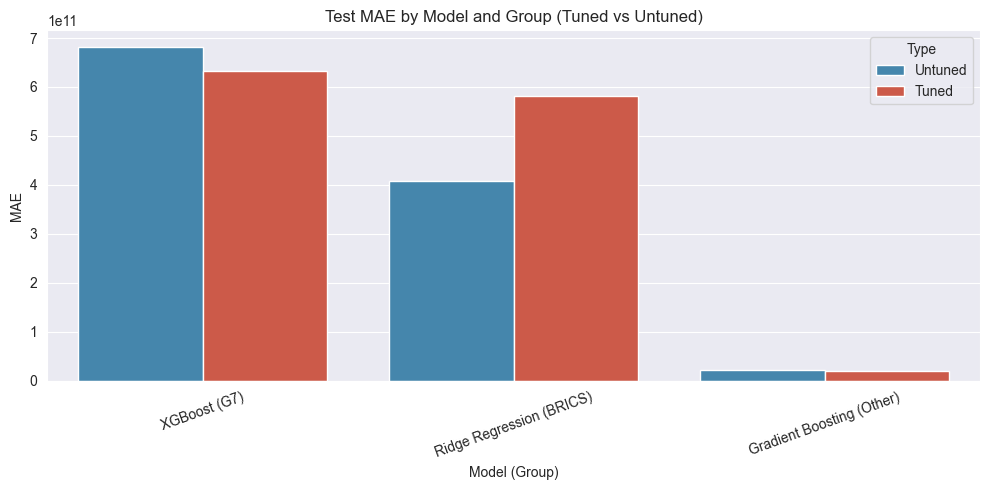

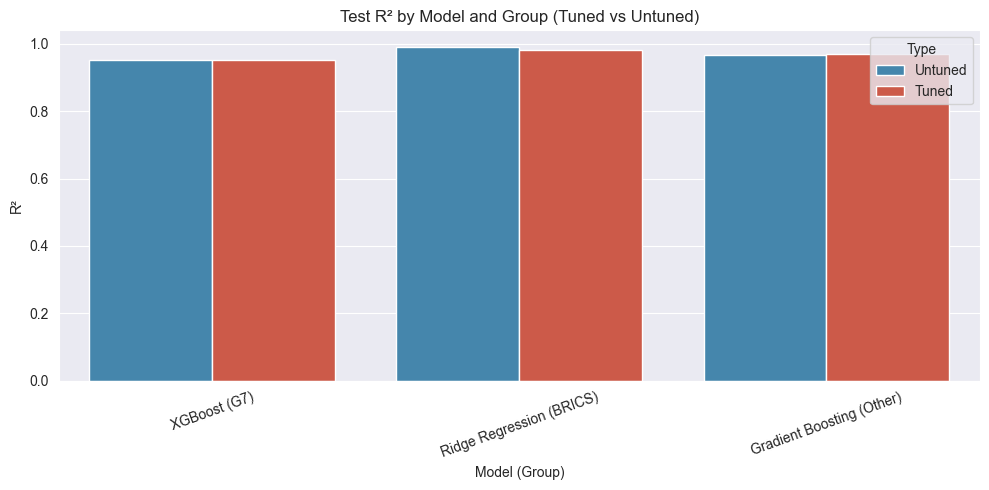

In [49]:

compare_df['Label'] = compare_df['Model'] + ' (' + compare_df['Group'] + ')'
label_order = compare_df.sort_values(['Group', 'Type'])['Label'].unique().tolist()

plt.figure(figsize=(10,5))
sns.barplot(
    data=compare_df,
    x='Label',
    y='Test RMSE',
    hue='Type',
    palette=['#348ABD', '#E24A33']
)
plt.title('Test RMSE by Model and Group (Tuned vs Untuned)')
plt.ylabel('RMSE')
plt.xlabel('Model (Group)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(
    data=compare_df,
    x='Label',
    y='Test MAE',
    hue='Type',
    palette=['#348ABD', '#E24A33']
)
plt.title('Test MAE by Model and Group (Tuned vs Untuned)')
plt.ylabel('MAE')
plt.xlabel('Model (Group)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(
    data=compare_df,
    x='Label',
    y='Test R2',
    hue='Type',
    palette=['#348ABD', '#E24A33']
)
plt.title('Test R² by Model and Group (Tuned vs Untuned)')
plt.ylabel('R²')
plt.xlabel('Model (Group)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [50]:
best_models = {
    'Other': gb_tuned,
    'BRICS': ridge_untuned,
    'G7': xgb_untuned
}

In summary, tuning did not universally improve performance. In two cases (G7 and BRICS), untuned models generalized better, while for the diverse "Other" group, tuning yielded clear benefits. This highlights the importance of group-specific validation and careful model selection over assuming that tuning always leads to better results.

Interpretation



=== Other: Feature Importances (GradientBoostingRegressor) ===


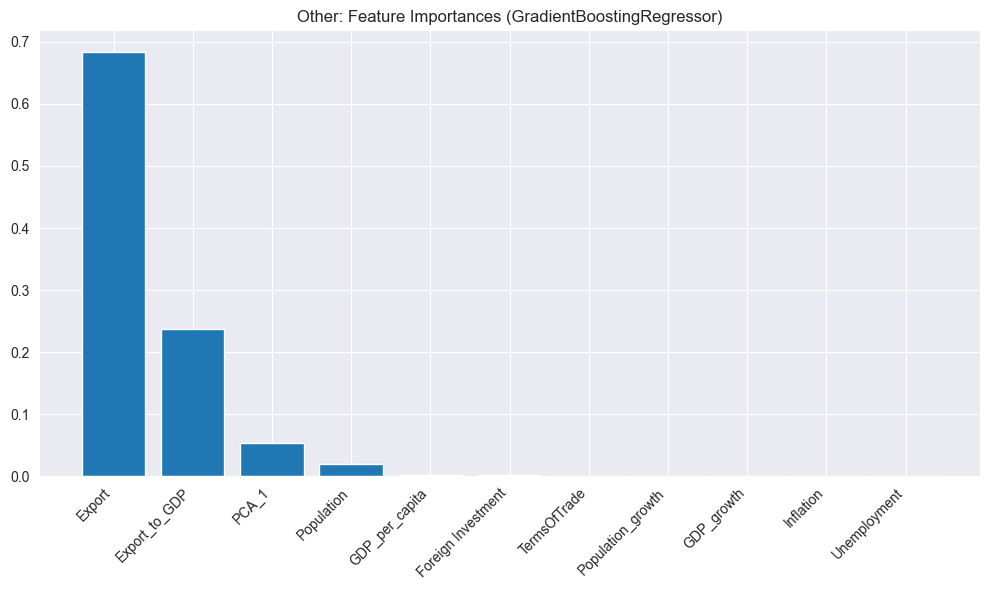

               Feature  Importance
3               Export    0.684165
9        Export_to_GDP    0.236815
10               PCA_1    0.054132
0           Population    0.019269
6       GDP_per_capita    0.002330
4   Foreign Investment    0.001438
5         TermsOfTrade    0.001248
8    Population_growth    0.000271
7           GDP_growth    0.000139
1            Inflation    0.000133
2         Unemployment    0.000059

=== BRICS: Feature Importances (Ridge) ===


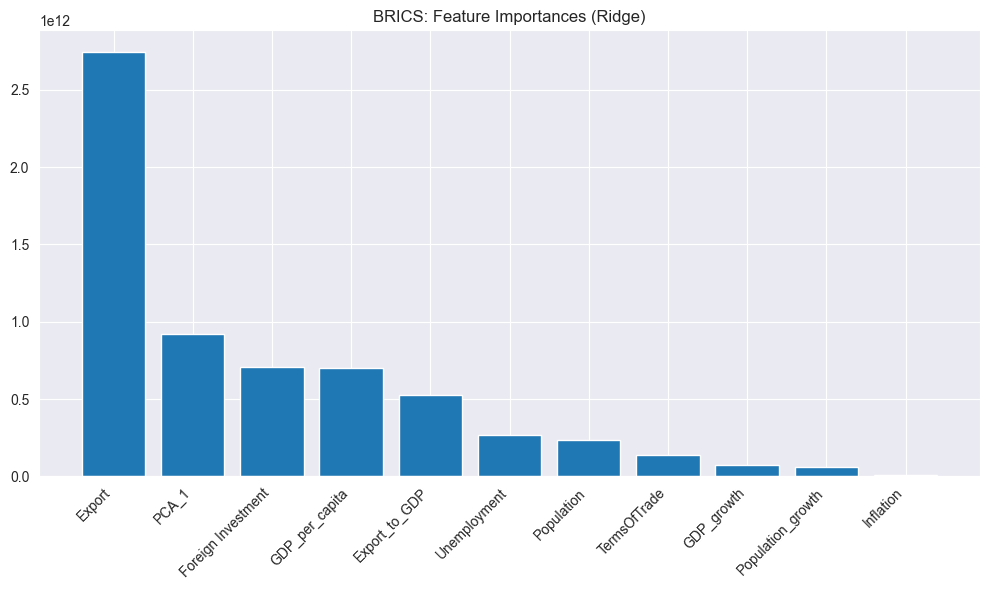

               Feature    Importance
3               Export  2.746455e+12
10               PCA_1  9.202533e+11
4   Foreign Investment  7.085087e+11
6       GDP_per_capita  6.988902e+11
9        Export_to_GDP  5.242255e+11
2         Unemployment  2.665114e+11
0           Population  2.334511e+11
5         TermsOfTrade  1.348070e+11
7           GDP_growth  7.212485e+10
8    Population_growth  6.300186e+10
1            Inflation  8.881194e+09

=== G7: Feature Importances (XGBRegressor) ===


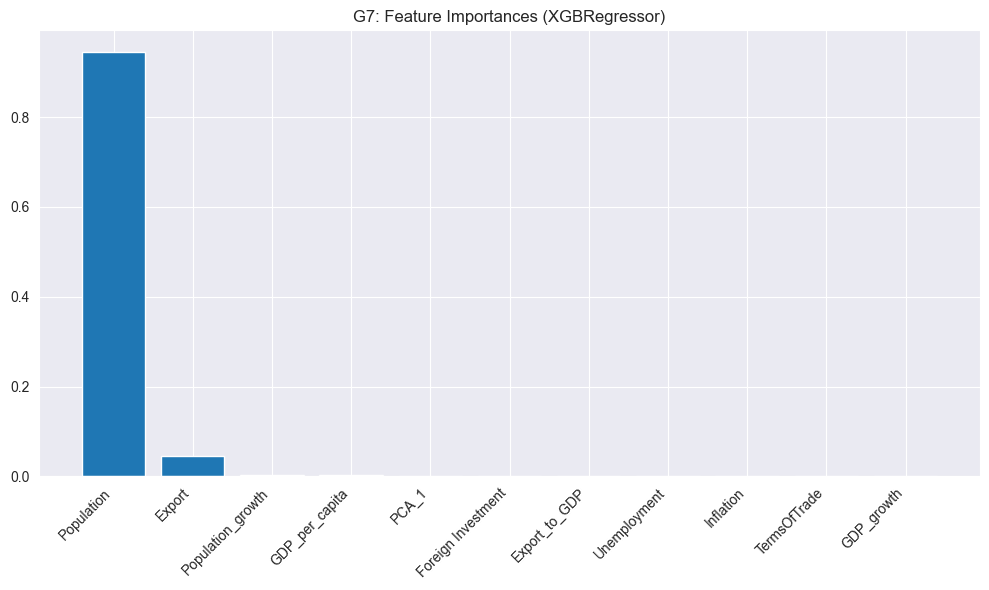

               Feature  Importance
0           Population    0.945831
3               Export    0.046333
8    Population_growth    0.004046
6       GDP_per_capita    0.002093
10               PCA_1    0.000731
4   Foreign Investment    0.000427
9        Export_to_GDP    0.000368
2         Unemployment    0.000066
1            Inflation    0.000039
5         TermsOfTrade    0.000038
7           GDP_growth    0.000028


In [51]:
exclude = ['GDP', 'Country', 'Year', 'Group']
feature_cols = [col for col in df.columns if col not in exclude]


for group, model in best_models.items():
    print(f"\n=== {group}: Feature Importances ({type(model).__name__}) ===")

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_)
    else:
        print(f"⚠️ Model for {group} does not support feature importances!")
        continue

    fi_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(fi_df['Feature'], fi_df['Importance'])
    plt.title(f'{group}: Feature Importances ({type(model).__name__})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(fi_df)


Feature Importance Analysis (Summary for All Groups)

Analysis of feature importances for the best model in each country group reveals clear differences in the economic drivers of GDP:

    Other Countries (Gradient Boosting):
    Export and the export-to-GDP ratio are by far the most influential predictors of GDP, accounting for more than 90% of model importance. The first principal component (PCA_1) also contributes meaningfully, while demographic and macroeconomic growth features (like inflation, unemployment, population growth) have only marginal impact.

    BRICS (Ridge Regression):
    While export remains the strongest driver, the model also assigns notable weight to PCA_1, the export-to-GDP ratio, and foreign investment. Unemployment and population matter as well, but less so. Inflation and terms of trade play only a minor role.

    G7 (XGBoost):
    In developed economies, the single most powerful feature is population, dominating all others. Export comes next, but with much less impact. Most macroeconomic variables—including inflation, unemployment, and even foreign investment—are nearly negligible in their predictive contribution.

Overall, these results underscore two key insights:

    External trade is a major driver of GDP for developing and mixed economies, while in the most developed countries, demographic scale (population size) becomes the primary determinant of absolute GDP levels.

    Composite features like PCA_1 (principal components) can capture complex macroeconomic effects and are valuable even when raw macro indicators have low standalone importance.

In [52]:

final_group_models = {}
final_group_scalers = {}

for group in ['G7', 'BRICS', 'Other']:

    group_df = df[(df['Group'] == group) & (df['Year'] <= 2023)]
    X_full = group_df[feature_cols]
    y_full = group_df['GDP']

    scaler = StandardScaler()
    X_full_scaled = scaler.fit_transform(X_full)

    model = best_models[group]
    model.fit(X_full_scaled, y_full)

    final_group_models[group] = model
    final_group_scalers[group] = scaler

    print(f"✅ Trained final model for {group}: {type(model).__name__}")



✅ Trained final model for G7: XGBRegressor
✅ Trained final model for BRICS: Ridge
✅ Trained final model for Other: GradientBoostingRegressor


Future

In [53]:
def forecast_population_growth(df, years_to_predict):
    forecasts = []
    for country in df['Country'].unique():
        country_df = df[df['Country'] == country].sort_values('Year')
        pop_values = country_df['Population'].values
        year_values = country_df['Year'].values

        if len(pop_values) < 5:
            continue

        avg_growth = np.diff(pop_values[-5:]).mean()
        last_year = year_values[-1]
        last_value = pop_values[-1]

        for year in years_to_predict:
            y_pred = last_value + avg_growth * (year - last_year)
            forecasts.append({'Country': country, 'Year': year, 'Population': max(0, round(y_pred))})
    return pd.DataFrame(forecasts)


In [54]:
def forecast_flat_median(df, feature, years_to_predict, n_years=5):
    forecasts = []
    for country in df['Country'].unique():
        country_df = df[df['Country'] == country].sort_values('Year')
        y = country_df[feature].dropna().values

        if len(y) < 2:
            continue

        median_val = np.median(y[-n_years:])
        for year in years_to_predict:
            forecasts.append({'Country': country, 'Year': year, feature: median_val})
    return pd.DataFrame(forecasts)


In [55]:
def forecast_growth(df, feature, years_to_predict, n_years=5):
    forecasts = []
    for country in df['Country'].unique():
        df_country = df[df['Country'] == country].sort_values('Year')
        y = df_country[feature].dropna().values
        x = df_country['Year'].values

        if len(y) < n_years:
            continue

        avg_growth = np.diff(y[-n_years:]).mean()
        last_year = x[-1]
        last_value = y[-1]

        for year in years_to_predict:
            y_pred = last_value + avg_growth * (year - last_year)
            forecasts.append({'Country': country, 'Year': year, feature: max(0, y_pred)})
    return pd.DataFrame(forecasts)


In [56]:
future_years = np.arange(2024, 2031)
future_features = {}

for group in ['G7', 'BRICS', 'Other']:
    group_df = df[df['Group'] == group]

    pop_future          = forecast_population_growth(group_df[['Country', 'Year', 'Population']], future_years)
    export_future       = forecast_growth(group_df[['Country', 'Year', 'Export']], 'Export', future_years)
    fdi_future          = forecast_growth(group_df[['Country', 'Year', 'Foreign Investment']], 'Foreign Investment', future_years)
    terms_future        = forecast_flat_median(group_df[['Country', 'Year', 'TermsOfTrade']], 'TermsOfTrade', future_years)
    inflation_future    = forecast_flat_median(group_df[['Country', 'Year', 'Inflation']], 'Inflation', future_years)
    unemployment_future = forecast_flat_median(group_df[['Country', 'Year', 'Unemployment']], 'Unemployment', future_years)

    future_df = pop_future \
        .merge(export_future, on=['Country', 'Year'], how='outer') \
        .merge(fdi_future, on=['Country', 'Year'], how='outer') \
        .merge(terms_future, on=['Country', 'Year'], how='outer') \
        .merge(inflation_future, on=['Country', 'Year'], how='outer') \
        .merge(unemployment_future, on=['Country', 'Year'], how='outer')

    future_features[group] = future_df

In [57]:
future_df.head(20)



,Country,Year,Population,Export,Foreign Investment,TermsOfTrade,Inflation,Unemployment
0,Afghanistan,2024,42354421,3.008571e+09,1.064853e+08,106.029777,5.133203,11.994
1,Afghanistan,2025,43254081,3.126273e+09,1.231015e+08,106.029777,5.133203,11.994
2,Afghanistan,2026,44153741,3.243976e+09,1.397176e+08,106.029777,5.133203,11.994
3,Afghanistan,2027,45053401,3.361679e+09,1.563338e+08,106.029777,5.133203,11.994
4,Afghanistan,2028,45953061,3.479381e+09,1.729499e+08,106.029777,5.133203,11.994
5,Afghanistan,2029,46852721,3.597084e+09,1.895661e+08,106.029777,5.133203,11.994
6,Afghanistan,2030,47752381,3.714787e+09,2.061822e+08,106.029777,5.133203,11.994
7,Albania,2024,2718917,1.017531e+10,1.725973e+09,103.721889,2.041472,11.466
8,Albania,2025,2691862,1.124609e+10,1.830963e+09,103.721889,2.041472,11.466
9,Albania,2026,2664808,1.231687e+10,1.935953e+09,103.721889,2.041472,11.466


In [58]:
future_df.shape


(917, 8)

In [59]:
feature_cols = [
    'Population', 'Inflation', 'Unemployment', 'Export', 'Foreign Investment',
    'TermsOfTrade', 'GDP_per_capita','GDP_growth', 'Population_growth', 'Export_to_GDP', 'PCA_1'
]

for group in ['G7', 'BRICS', 'Other']:
    f = future_features[group]

    for col in feature_cols:
        if col not in f.columns:
            f[col] = 0

    X_future = f[feature_cols]
    scaler = final_group_scalers[group]
    X_future_scaled = scaler.transform(X_future)
    model = final_group_models[group]
    y_pred = model.predict(X_future_scaled)
    f['Predicted_GDP'] = y_pred



In [60]:
    f['Export_to_GDP'] = f['Export'] / f['Predicted_GDP']
    f['GDP_growth'] = f.groupby('Country')['Predicted_GDP'].pct_change()
    f['Population_growth'] = f.groupby('Country')['Population'].pct_change()

    f[['Export_to_GDP', 'GDP_growth', 'Population_growth']] = f[['Export_to_GDP', 'GDP_growth', 'Population_growth']].fillna(0)



    X_pca_scaled = scaler_pca.transform(f[pca_features])
    f['PCA_1'] = pca.transform(X_pca_scaled)[:, 0]



In [61]:
for group in ['G7', 'BRICS', 'Other']:
    f = future_features[group]

    for col in feature_cols:
        if col not in f.columns:
            f[col] = 0

    X_future = f[feature_cols]
    scaler = final_group_scalers[group]
    model = final_group_models[group]
    X_future_scaled = scaler.transform(X_future)
    y_pred = model.predict(X_future_scaled)
    f['Predicted_GDP'] = y_pred

    f['Export_to_GDP'] = f['Export'] / f['Predicted_GDP']
    f['GDP_growth'] = f.groupby('Country')['Predicted_GDP'].pct_change()
    f['Population_growth'] = f.groupby('Country')['Population'].pct_change()
    f[['Export_to_GDP', 'GDP_growth', 'Population_growth']] = f[['Export_to_GDP', 'GDP_growth', 'Population_growth']].fillna(0)

    pca_features = [
        'Population', 'Inflation', 'Unemployment', 'Export',
        'Foreign Investment', 'TermsOfTrade',
        'GDP_growth', 'Population_growth', 'Export_to_GDP'
    ]
    f[pca_features] = f[pca_features].fillna(0)
    X_pca_scaled = scaler_pca.transform(f[pca_features])
    f['PCA_1'] = pca.transform(X_pca_scaled)[:, 0]

    X_future_final = f[feature_cols]
    X_future_final_scaled = scaler.transform(X_future_final)
    y_pred_final = model.predict(X_future_final_scaled)
    f['Predicted_GDP'] = y_pred_final

    future_features[group] = f

    print(f"✅ Ready for {group}: {len(f)} rows, first year: {f['Year'].min()}")

future_all = pd.concat([future_features[group] for group in ['G7', 'BRICS', 'Other']], ignore_index=True)


✅ Ready for G7: 49 rows, first year: 2024
✅ Ready for BRICS: 28 rows, first year: 2024
✅ Ready for Other: 917 rows, first year: 2024


In [62]:
future_all.head(15)

,Country,Year,Population,Export,Foreign Investment,TermsOfTrade,Inflation,Unemployment,GDP_per_capita,GDP_growth,Population_growth,Export_to_GDP,PCA_1,Predicted_GDP
0,Canada,2024,40717578,7.526240e+11,4.035973e+10,105.303128,3.395193,5.690,0,0.000000,0.000000,0.261375,1.853840,2.486765e+12
1,Canada,2025,41337394,7.903204e+11,3.864321e+10,105.303128,3.395193,5.690,0,-0.017469,0.015222,0.279347,1.778576,2.562497e+12
2,Canada,2026,41957210,8.280168e+11,3.692670e+10,105.303128,3.395193,5.690,0,0.000000,0.014994,0.292671,1.827491,2.532992e+12
3,Canada,2027,42577027,8.657132e+11,3.521018e+10,105.303128,3.395193,5.690,0,0.026064,0.014773,0.298222,1.874772,2.674758e+12
4,Canada,2028,43196844,9.034096e+11,3.349367e+10,105.303128,3.395193,5.690,0,0.000000,0.014558,0.311208,1.937274,2.649903e+12
5,Canada,2029,43816660,9.411059e+11,3.177715e+10,105.303128,3.395193,5.690,0,0.012507,0.014349,0.320189,1.988203,2.717529e+12
6,Canada,2030,44436476,9.788023e+11,3.006064e+10,105.303128,3.395193,5.690,0,0.000000,0.014146,0.333014,2.046370,2.700703e+12
7,France,2024,68513844,1.083832e+12,0.000000e+00,97.988534,1.642331,7.874,0,0.000000,0.000000,0.346853,2.042458,2.994659e+12
8,France,2025,68740200,1.121496e+12,0.000000e+00,97.988534,1.642331,7.874,0,0.000000,0.003304,0.358906,2.087697,2.994728e+12
9,France,2026,68966556,1.159159e+12,0.000000e+00,97.988534,1.642331,7.874,0,0.000000,0.003293,0.370960,2.161783,2.994799e+12


In [63]:
df_history = df[df['Year'] <= 2023].copy()
df_history['Predicted_GDP'] = df_history['GDP']

full_results = pd.concat([df_history, future_all], ignore_index=True)




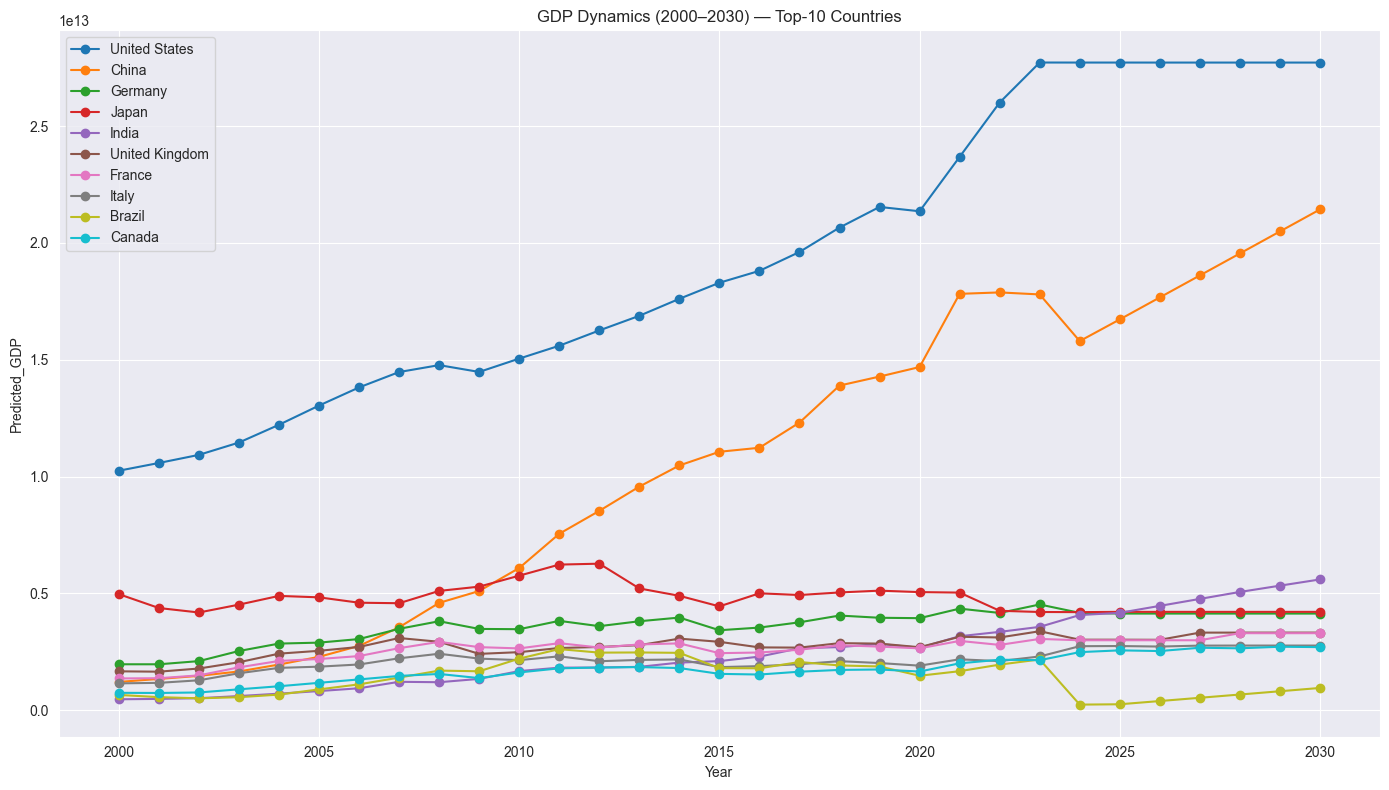

['United States', 'China', 'Germany', 'Japan', 'India', 'United Kingdom', 'France', 'Italy', 'Brazil', 'Canada']


In [64]:

last_real_year = full_results[full_results['Year'] <= 2023]['Year'].max()
top10 = (
    full_results[full_results['Year'] == last_real_year]
    .sort_values('Predicted_GDP', ascending=False)
    .head(10)['Country']
    .tolist()
)

plt.figure(figsize=(14, 8))
for country in top10:
    data = full_results[full_results['Country'] == country].sort_values('Year')
    plt.plot(data['Year'], data['Predicted_GDP'], marker='o', label=country)

plt.xlabel('Year')
plt.ylabel('Predicted_GDP')
plt.title('GDP Dynamics (2000–2030) — Top-10 Countries')
plt.legend()
plt.tight_layout()
plt.show()

print(top10)

Comparison with IMF

In [65]:

imf_raw = pd.read_csv('imf2.csv')



In [66]:
imf_raw

,Country,Year,IMF_GDP
0,Afghanistan,2024,NaN
1,Albania,2024,27.259
2,Algeria,2024,264.913
3,Andorra,2024,4.038
4,Angola,2024,115.946
...,...,...,...
1367,Vietnam,2030,666.539
1368,West Bank and Gaza,2030,NaN
1369,Yemen,2030,25.717
1370,Zambia,2030,50.669


In [67]:

gdp_countries = set(df['Country'].unique())
imf_countries = set(imf_raw['Country'].unique())

imf_not_in_gdp = [c for c in imf_countries if c not in gdp_countries]
gdp_not_in_imf = [c for c in gdp_countries if c not in imf_countries]

print(imf_not_in_gdp)
print(gdp_not_in_imf)

['Trinidad and Tobago', 'Nigeria', 'Somalia', 'Venezuela', 'Kiribati', "China, People's Republic of", 'Switzerland', 'Lao P.D.R.', 'Czech Republic', 'Andorra', 'Saint Kitts and Nevis', 'South Sudan, Republic of', 'Moldova', 'S�o Tom� and Pr�ncipe', 'Congo, Republic of ', 'Micronesia, Fed. States of', 'Kosovo', 'Grenada', 'North Macedonia ', 'Saint Vincent and the Grenadines', 'Vietnam', 'Montenegro', 'Bolivia', 'Seychelles', 'Korea, Republic of', 'Bahamas, The', 'Gambia, The', 'Turkmenistan', 'Yemen', 'Aruba', 'Puerto Rico', 'Hong Kong SAR', 'Syria', 'T�rkiye, Republic of', 'Macao SAR', 'Antigua and Barbuda', 'Eritrea', 'West Bank and Gaza', 'Palau', 'Taiwan Province of China', 'Nauru', 'Malawi', 'Tanzania', 'Myanmar', 'Kyrgyz Republic', 'Congo, Dem. Rep. of the', 'Tuvalu', 'Timor-Leste', 'Eswatini', 'Egypt', 'Barbados', 'Liberia', 'Iran', "C�te d'Ivoire", 'Slovak Republic', 'Dominica', 'Saint Lucia', 'San Marino', 'Marshall Islands', 'Argentina']
['North Macedonia', 'Czechia', 'China'

In [68]:
imf_raw['Country'] = imf_raw['Country'].replace({
    "China, People's Republic of": 'China',
    "Taiwan Province of China": 'Taiwan',
    "Slovak Republic": "Slovakia",
    "Bahamas, The": "Bahamas",
    "Congo, Dem. Rep. of the": "Congo, Democratic Republic of the",
    "Kyrgyz Republic": "Kyrgyzstan",
    "South Sudan, Republic of": "South Sudan",
    "Hong Kong SAR": "Hong Kong",
    "Saint Lucia": "St. Lucia",
    "Saint Vincent and the Grenadines": "St. Vincent and the Grenadines",
    "Saint Kitts and Nevis": "St. Kitts and Nevis",
    "Korea, Republic of": "South Korea",
    "Macao SAR": "Macau",
    "Czech Republic": "Czechia",
    "Venezuela": "Venezuela, RB",
    "Tanzania": "Tanzania",
    "Vietnam": "Viet Nam",
    "T�rkiye, Republic of": "Turkey",
    "Congo, Republic of ": "Congo, Rep.",
    "Micronesia, Fed. States of": "Micronesia, Fed. Sts.",
    "Taiwan": "Taiwan, China",
    "Bolivia": "Bolivia",
    "Iran": "Iran, Islamic Rep.",
    "Lao P.D.R.": "Lao PDR",
    "Yemen": "Yemen, Rep.",
    "Kosovo": "Kosovo",
    "West Bank and Gaza": "West Bank and Gaza",
    "Syria": "Syrian Arab Republic",
    "Egypt": "Egypt, Arab Rep.",
    "S�o Tom� and Pr�ncipe": "Sao Tome and Principe",
    "Gambia, The": "Gambia, The",
    "North Macedonia ": "North Macedonia",
    "C�te d'Ivoire": "Cote d'Ivoire",
})


In [69]:

compare = pd.merge(
    full_results[['Country', 'Year', 'Predicted_GDP']],
    imf_raw,
    on=['Country', 'Year'],
    how='inner'
)

compare['Predicted_GDP'] = compare['Predicted_GDP'] / 1_000_000_000

print(compare.head())


  Country  Year  Predicted_GDP   IMF_GDP
0  Canada  2024    2486.765093  2241.253
1  Canada  2025    2562.497446  2225.341
2  Canada  2026    2532.991566  2332.563
3  Canada  2027    2674.757992  2435.529
4  Canada  2028    2649.903333  2542.339


In [70]:
print(imf_raw[(imf_raw['Country'].str.contains('China')) & (imf_raw['Year'] == 2030)])

     Country  Year    IMF_GDP
1212   China  2030  25827.523


In [71]:
compare

,Country,Year,Predicted_GDP,IMF_GDP
0,Canada,2024,2486.765093,2241.253
1,Canada,2025,2562.497446,2225.341
2,Canada,2026,2532.991566,2332.563
3,Canada,2027,2674.757992,2435.529
4,Canada,2028,2649.903333,2542.339
...,...,...,...,...
982,Zimbabwe,2026,33.655162,39.491
983,Zimbabwe,2027,32.534651,40.925
984,Zimbabwe,2028,32.534651,42.340
985,Zimbabwe,2029,32.534651,43.836


In [72]:
top3 = (
    compare[compare['Year'] >= 2024]
    .groupby('Country')['Predicted_GDP']
    .mean()
    .sort_values(ascending=False)
    .head(3)
    .index
    .tolist()
)
print(top3)



['United States', 'China', 'India']


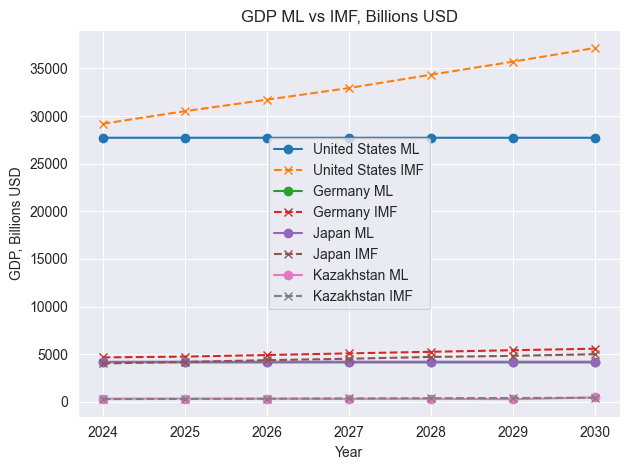

In [73]:


for country in ['United States', 'Germany', 'Japan','Kazakhstan']:
    c = compare[compare['Country'] == country]
    plt.plot(c['Year'], c['Predicted_GDP'], marker='o', label=f'{country} ML')
    plt.plot(c['Year'], c['IMF_GDP'], marker='x', linestyle='--', label=f'{country} IMF')

plt.xlabel('Year')
plt.ylabel('GDP, Billions USD')
plt.title('GDP ML vs IMF, Billions USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


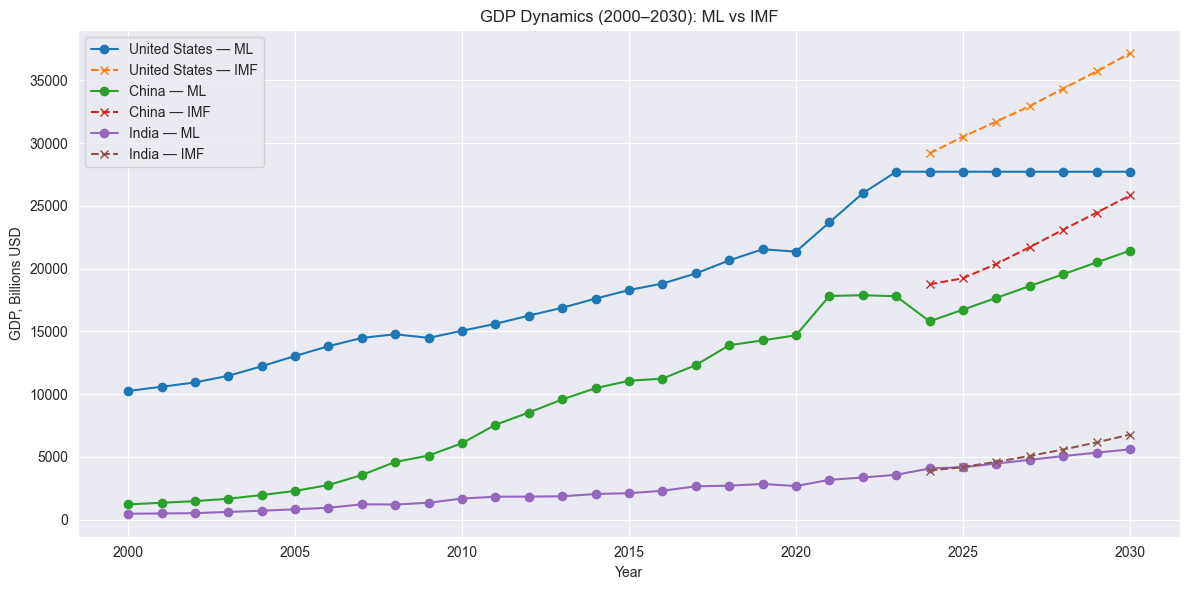

In [74]:

plt.figure(figsize=(12, 6))
for country in top3:

    c_ml = full_results[(full_results['Country'] == country) & (full_results['Year'] >= 2000)]
    plt.plot(
        c_ml['Year'],
        c_ml['Predicted_GDP'] / 1_000_000_000,  # в миллиардах
        label=f'{country} — ML',
        marker='o'
    )

    c_imf = imf_raw[(imf_raw['Country'] == country) & (imf_raw['Year'] >= 2024)]
    plt.plot(
        c_imf['Year'],
        c_imf['IMF_GDP'],
        label=f'{country} — IMF',
        marker='x',

        linestyle='--'
    )

plt.xlabel('Year')
plt.ylabel('GDP, Billions USD')
plt.title('GDP Dynamics (2000–2030): ML vs IMF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



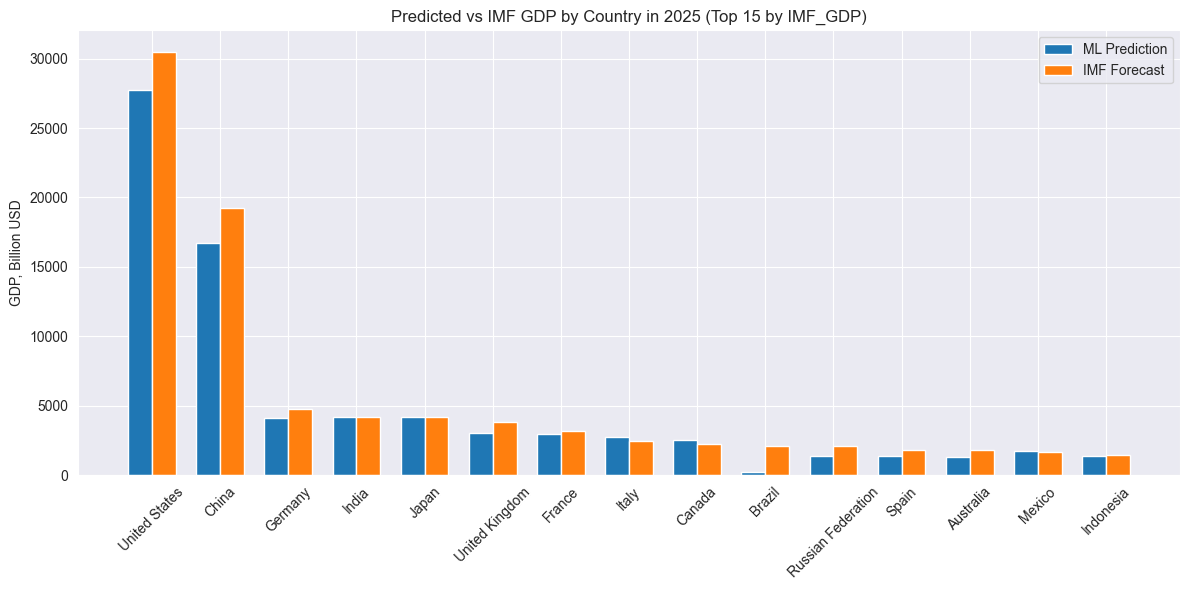

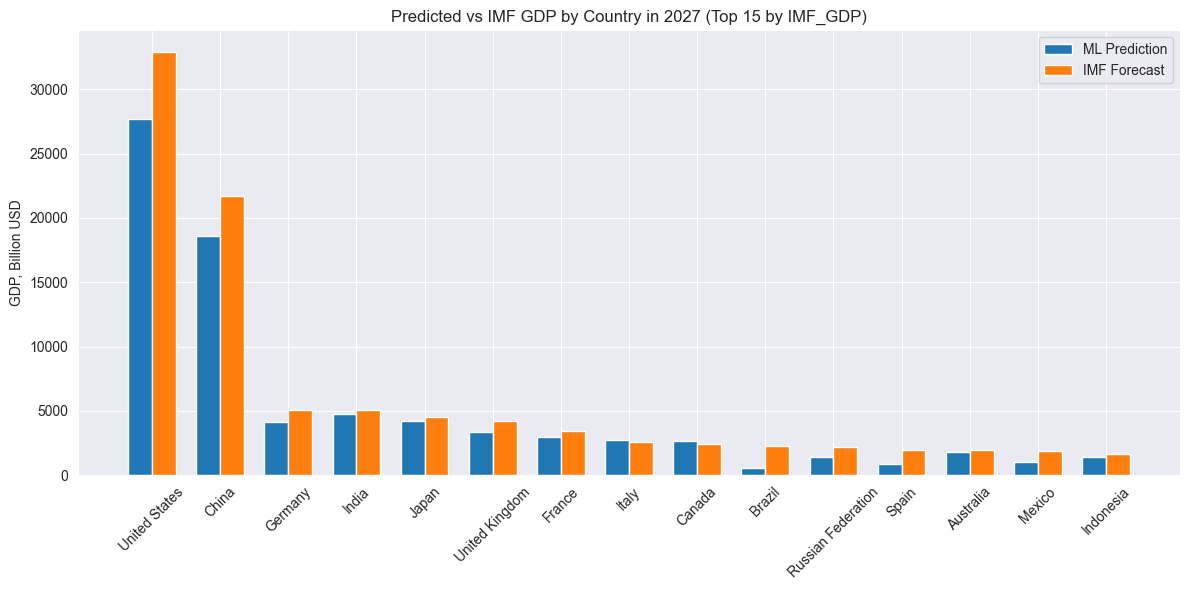

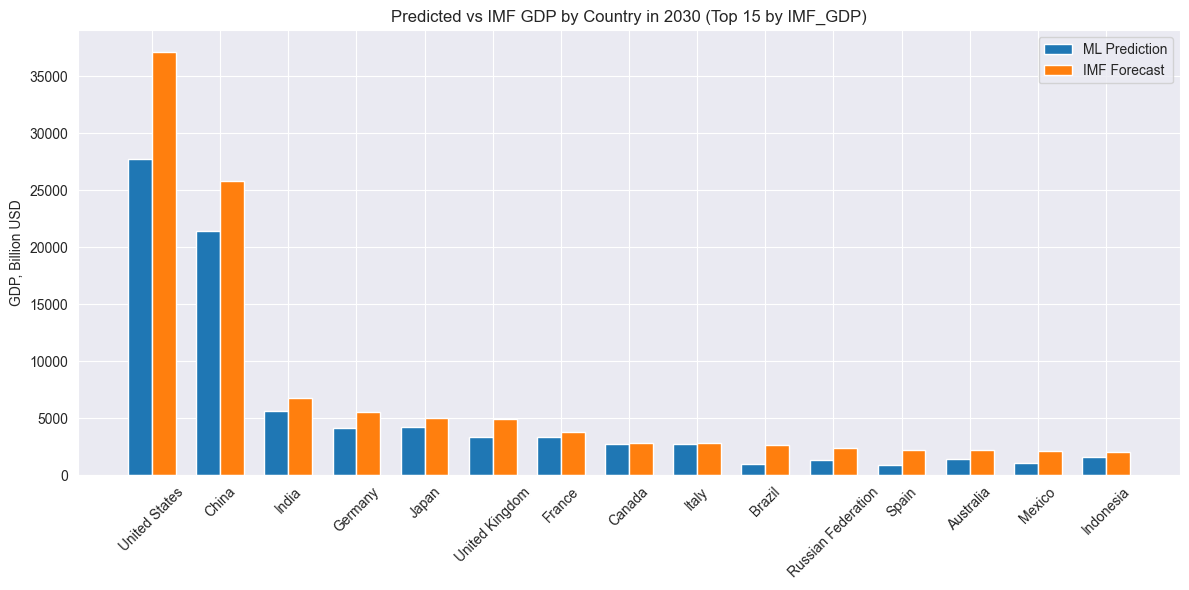

In [75]:
def plot_pred_vs_imf_bar(year, top_n=10, sort_by='Predicted_GDP'):
    df_pred = full_results[full_results['Year'] == year][['Country', 'Predicted_GDP']].copy()
    df_pred['Predicted_GDP'] = df_pred['Predicted_GDP'] / 1_000_000_000

    df_imf = imf_raw[imf_raw['Year'] == year][['Country', 'IMF_GDP']].copy()

    compare = pd.merge(df_pred, df_imf, on='Country')

    compare = compare.sort_values(sort_by, ascending=False).head(top_n)

    bar_width = 0.35
    x = range(len(compare))
    plt.figure(figsize=(12,6))
    plt.bar(x, compare['Predicted_GDP'], width=bar_width, label='ML Prediction')
    plt.bar([i + bar_width for i in x], compare['IMF_GDP'], width=bar_width, label='IMF Forecast')
    plt.xticks([i + bar_width/2 for i in x], compare['Country'], rotation=45)
    plt.ylabel('GDP, Billion USD')
    plt.title(f'Predicted vs IMF GDP by Country in {year} (Top {top_n} by {sort_by})')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pred_vs_imf_bar(2025, top_n=15, sort_by='IMF_GDP')
plot_pred_vs_imf_bar(2027, top_n=15, sort_by='IMF_GDP')
plot_pred_vs_imf_bar(2030, top_n=15, sort_by='IMF_GDP')

This analysis emphasizes both the strengths and limitations of purely historical machine learning forecasts:

    ML models excel at providing objective, transparent forecasts grounded in historical economic patterns, particularly effective in stable-growth or rapidly developing scenarios.

    However, they inherently miss future external shocks, policy innovations, and transformative technological or structural changes.

    A comprehensive approach to GDP forecasting should ideally integrate ML-driven, data-based insights with expert-driven IMF-style projections to create robust, scenario-aware economic outlooks.

Thus, our model serves as a powerful complement to traditional forecasting methods, providing a rigorous baseline from which scenario analyses and policy-based forecasts can be effectively constructed.